# Install Packages

In [ ]:
!pip install pyhocon
!pip install scikit-learn-extra

     |████████████████████████████████| 112kB 14.6MB/s 
  Created wheel for pyhocon: filename=pyhocon-0.3.57-cp36-none-any.whl size=18542 sha256=72b5b5ce007f1249087cfb82a0695c6517a44023a1f49f1136997508793cdca1
  Stored in directory: /root/.cache/pip/wheels/43/ae/39/250b80e3aa8082c5fbb3f14782b9cad47de0b885f22e927a8f
Successfully built pyhocon
     |████████████████████████████████| 624kB 14.1MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for scikit-learn-extra: filename=scikit_learn_extra-0.1.0b2-cp36-cp36m-linux_x86_64.whl size=340323 sha256=0ac8f27a63aa63e35a2707e204c4079eb6a418872863465a26be957e259e39c2
  Stored in directory: /root/.cache/pip/wheels/04/01/0f/943bffb48bac048fa216b4325f1a6c939491ccb0ff500e08f4
Successfully built scikit-learn-extra


# Import Packages

In [ ]:
# Default

import os
import sys
import math
import random
import pyhocon
import argparse
import itertools
import matplotlib.pyplot as plt
from collections import defaultdict



# PyTorch

import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable


# Sklearn

from sklearn.utils import shuffle
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

# Utility
import community as community_louvain
import networkx as nx
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.patheffects as PathEffects
import time


# Louvain: Community Detection


```
*   Find communities based weighted modularity
*   Weight of an edge between two nodes u and v, W_(uv) = MI(F_u, F_v)
```



In [ ]:
class Louvain():

  def __init__(self):
    pass

  def init_graph(self, edges, weights):

    assert not torch.isnan(weights).any()
    assert not torch.isinf(weights).any()

    self.G = nx.Graph()


    for i in range(len(edges[0])):
      self.G.add_edge(edges[0][i], edges[1][i], weight = max(0, weights[i]))

    
    links = self.G.size( weight ="weight")

    if links == 0:
      self.G = nx.Graph()
      weights = torch.ones(weights.shape)
      for i in range(len(edges[0])):
        self.G.add_edge(edges[0][i], edges[1][i], weight = (weights[i]))

  def find_communities(self, edges, weights):
    
    self.init_graph(edges, weights)

    self.communities = community_louvain.best_partition(self.G)
    modularity_value = community_louvain.modularity(self.communities, self.G)
  
    self.make_community_matrix()
    
    print('Modularity : ', modularity_value)
    print("# Communities : ",len(self.com_dic))

    return self.com_dic, self.communities

  
  def make_community_matrix(self):
    self.com_dic = dict()
    for nd in self.communities:
      if self.communities[nd] not in self.com_dic:
        self.com_dic[self.communities[nd]] = list()
      self.com_dic[self.communities[nd]].append(nd)
    return self.com_dic, self.communities


  def get_purity(self, labels):
    partition = self.communities

    com2cls_dic = dict()
    cls2com_dic = dict()

    total = 0

    for node in partition:
      if partition[node] not in com2cls_dic:
        com2cls_dic[partition[node]] = dict()
      if str(labels[node]) not in com2cls_dic[partition[node]]:
        com2cls_dic[partition[node]][str(labels[node])] = 0
      com2cls_dic[partition[node]][str(labels[node])] += 1
      
      if str(labels[node]) not in cls2com_dic:
        cls2com_dic[str(labels[node])] = set()
      cls2com_dic[str(labels[node])] |= set([partition[node]])

      total += 1;

    assert total == len(labels)
    
    purity = 0
    for com in com2cls_dic:
      
      mx = -1
      for cls in com2cls_dic[com]:
        mx = max(mx, com2cls_dic[com][cls])
      purity += mx      
  

    purity /= total
    print('-------- Community purity: ', purity,  '----------')
    for c in com2cls_dic:
      print('Com: ', c, ' - ', len(com2cls_dic[c]), ' : ', com2cls_dic[c])
    
    return purity


    # for cls in cls2com_dic:
    #   print('Class: ', cls, ' Communities: ', len(cls2com_dic[cls]),  sorted(cls2com_dic[cls]))

  
  def determine_local_centralities(self, edges, weights, nodes):
    self.init_graph(edges, weights)
    self.lmv_dic = dict()
    self.deg_centrality(self.G, nodes)
    self.closeness(self.G, nodes)
    self.betweenness(self.G, nodes)
    self.clustering_coefficient(self.G, nodes)
    return self.lmv_dic
  


  def deg_centrality(self, g, nodes):
    deg_centrality = nx.degree_centrality(g)
    
    assert len(deg_centrality) == len(nodes)
    for u in deg_centrality:
      if u not in self.lmv_dic:
        self.lmv_dic[u] = []
      self.lmv_dic[u].append(deg_centrality[u])
    return
  
  
  def betweenness(self, g, nodes):
    bet_centrality = nx.betweenness_centrality(g, normalized = True,  endpoints = False)
    assert len(bet_centrality) == len(nodes)
    for u in bet_centrality:
      if u not in self.lmv_dic:
        self.lmv_dic[u] = []
      self.lmv_dic[u].append(bet_centrality[u]) 
    return
  
  def closeness(self, g, nodes):
    close_centrality = nx.closeness_centrality(g)
    assert len(close_centrality) == len(nodes)
    for u in close_centrality:
      if u not in self.lmv_dic:
        self.lmv_dic[u] = []
      self.lmv_dic[u].append(close_centrality[u]) 
    return
  
  
  def clustering_coefficient(self, g, nodes):
    lcc = nx.clustering(g)
    assert len(lcc) == len(nodes)
    for u in lcc:
      if u not in self.lmv_dic:
        self.lmv_dic[u] = []
      self.lmv_dic[u].append(lcc[u])
    return
  

# Community Representative Formation


```
1. Mean Readout - Compute average of all nodes' feature within a community
2. Attentive Readout - Attention value for a node would be computed based on its centralities
```

## Attentive Readout

In [ ]:
class AttentiveReadout(nn.Module):
  def __init__(self, num_lcm):
    super(AttentiveReadout, self).__init__()
    self.num_lcm = num_lcm
    self.AT = nn.Parameter(torch.FloatTensor(self.num_lcm, 1))
    self.init_params()


  def init_params(self):
    for param in self.parameters():
      nn.init.xavier_uniform_(param)
    return


  def forward(self, feat_mat, com_mat, lmv):

    assert lmv.shape[1] == self.num_lcm

    mask = torch.zeros((len(com_mat), feat_mat.shape[0]))

    for cm in range(0, len(com_mat)):
      neighs = list(com_mat[cm])
      mask[[cm], neighs] = 1

    mask = torch.unsqueeze(mask, -1)
    
    com_feats = lmv*mask

    btch_at = [self.AT for _ in range(com_feats.shape[0])]
    btch_at = torch.stack(btch_at)
    

    
    attn_mat = torch.bmm(com_feats, btch_at)
    
    # attn_mat = F.relu(attn_mat)
    # print("Attn Com Feats: ", attn_mat)

    attn_mat = torch.exp(attn_mat)
    
    # print(" Attn Exp: ", attn_mat)

    atexp_sum = torch.sum(attn_mat, 1)
    
    # print(atexp_sum)

    inverse_mask =  torch.ones(mask.shape)
    inverse_mask = inverse_mask - mask
    
    atexp_sum = atexp_sum - torch.sum(inverse_mask, 1)

    # print('extact exp_sum: ', atexp_sum)

    ext_atexp_sum = atexp_sum.repeat(1, feat_mat.shape[0]).view(attn_mat.shape[0], attn_mat.shape[1], attn_mat.shape[2])
    # print('expaned attn value ', ext_atexp_sum)

    attn_mat = attn_mat - inverse_mask
    attn_mat = attn_mat/ext_atexp_sum

    # print(attn_mat)

    atcom_feats = torch.sum(feat_mat * attn_mat, 1) 
    
    return atcom_feats

## Mean Readout

In [ ]:
def mean_readout(feat_mat, com_mat):
  com_mask = torch.zeros((len(com_mat), feat_mat.shape[0]))
  for idx in range(0, len(com_mat)):
    com_mask[[idx], com_mat[idx]] = 1
  com_mask = torch.unsqueeze(com_mask, -1)
  com_rep_feats = torch.sum(feat_mat * com_mask, 1) / torch.sum(com_mask, 1)
  return com_rep_feats

# MIC: MI based Clustering 


```
1. Initialization: partition whole set of data points equal to the number of clusters. Each partition would be considered as a cluster

2. Update: Assign target point into the cluster having its maximum average MI with all points in that cluster 

3. Terminate: until no change in clusters.

```



In [ ]:
class MIClustering(nn.Module):

  def __init__(self, n_clusters, embd_size, mx_itr = 303):
    super(MIClustering, self).__init__()
    self.n_clusters = n_clusters
    self.mx_itr = mx_itr
    self.init_params()

  
  def init_params(self):
    
    for param in self.parameters():
      nn.init.xavier_uniform_(param)
  


  def init_centers(self, data_points, labels=None, train_nodes=None):
  
    # training_limit = math.ceil(2*data_points.shape[0]/3)
    # indexes = random.sample([i for i in range(data_points.shape[0]) ], self.n_clusters)
    inds = torch.randperm(data_points.shape[0])
    # inds = inds[:training_limit].numpy()
    if labels is not None:
      # inds = inds.numpy()
      inds = train_nodes
      c2n_dic = dict()
      for n in inds:
        nd = n
        if labels[nd] not in c2n_dic:
          c2n_dic[labels[nd]] = list()
        c2n_dic[labels[nd]].append(nd)
    else:
      inds = torch.LongTensor(inds)
      inds = torch.split(inds, math.ceil(data_points.shape[0]/self.n_clusters), dim=0)
      c2n_dic = dict()
      cid = 0
      for i in inds:
        c2n_dic[cid] = list(i.numpy())
        # print('cid: ', labels[c2n_dic[cid]])
        # print('cid: ', c2n_dic[cid])
        cid += 1
    
    return c2n_dic



  def forward(self, feats, labels, mi_estimator, training):
    cur_itr = 0
    # if training is True:
    c2n_dic = self.init_centers(feats, labels, training)
    # print(c2n_dic)
    # print(" Clustering initialization: ")

    # for c in c2n_dic:
    #   tdic = dict()
    #   nds = c2n_dic[c]
    #   for n in nds:
    #     if labels[n] not in tdic:
    #       tdic[labels[n]] = 0
    #     tdic[labels[n]] += 1

    #   print("Cluster : ", c, ' classes: ', len(tdic), tdic)
    
    # print('------------end-----------------')
    # print('Random centers: ',centers)
    
    self.mi_mat = self.get_mi_matrix(feats, mi_estimator)
    cls2node_dic, node2cls_dic, n2c_mi = self.initial_assignment(feats, c2n_dic)
    # print('Intial ', len(cls2node_dic))
    # centers = self.update_centers(cls2node_dic, feats)
    # print('Intial centers: ', centers.shape, centers)
    # print(" Clustering initial assignment: ")
    
    # for c in cls2node_dic:
    #   tdic = dict()
    #   nds = cls2node_dic[c]
    #   for n in nds:
    #     if labels[n] not in tdic:
    #       tdic[labels[n]] = 0
    #     tdic[labels[n]] += 1

    #   print("Cluster : ", c, ' classes: ', len(tdic), tdic)
    # print('------------end-----------------')
    # print(node2cls_dic)
    converged = False
    while (cur_itr < self.mx_itr) and (not converged):
      # cls_mi, cls_ind = self.compute_mi(feats, centers)
      cls_mi, cls_ind = self.compute_cumulative_mi(feats, cls2node_dic)
      # print(cls_mi)
      # print(cls_ind)
      pre_c2n_dic = cls2node_dic
      cls2node_dic, node2cls_dic, n2c_mi = self.update_assignment(node2cls_dic, n2c_mi, cls_mi, cls_ind)
      
      # print('%%%%%%%%%%%%%%%%%%%%% start %%%%%%%%%%%%%%%%%')

      # for c in cls2node_dic:
      #   print(c , ' : ', cls2node_dic[c])
      #   tdic = dict()
      #   nds = cls2node_dic[c]
      #   for n in nds:
      #     if labels[n] not in tdic:
      #       tdic[labels[n]] = 0
      #     tdic[labels[n]] += 1

      #   print("Cluster : ", c, ' classes: ', len(tdic), tdic)
      #   # print("Cluster : ", c, ' communities: ', cls2node_dic[c])
      #   # print("Cluster : ", c, ' labels: ', labels[cls2node_dic[c]])
      # # print(node2cls_dic)
      # print('------------end-----------------')
      # nw_centers = self.update_centers(cls2node_dic, feats)

      converged = self.is_converge(pre_c2n_dic, cls2node_dic)
      cur_itr += 1

    # print("Converged: ", not (cur_itr >= self.mx_itr))
    self.c2n_dic = cls2node_dic
    self.n2c_dic = node2cls_dic
    
    return cls2node_dic, node2cls_dic



  def initial_assignment(self, feats, c2n_dic):
    
    cls_mi, cls_ind = self.compute_cumulative_mi(feats, c2n_dic)
    assert len(cls_mi) == feats.shape[0]

    cls2node_dic = dict()
    
    for i in range(feats.shape[0]):
      if cls_ind[i] not in cls2node_dic:
        cls2node_dic[cls_ind[i]] = []
      cls2node_dic[cls_ind[i]].append(i)
    
    return cls2node_dic, cls_ind, cls_mi



  def update_assignment(self, pre_n2c, pre_n2c_mi, nw_mi, nw_cls):
    
    nw_n2c = dict()
    nw_c2n = dict()
    nw_n2c_mi = dict()

    assert len(pre_n2c_mi) == len(nw_mi)
    assert len(pre_n2c) == len(nw_cls)
    assert len(pre_n2c_mi) == len(nw_cls)


    for i in nw_mi:
      
      if pre_n2c_mi[i] < nw_mi[i]:
        if nw_cls[i] not in nw_c2n:
          nw_c2n[nw_cls[i]] = []

        nw_n2c[i] = nw_cls[i] 
        nw_n2c_mi[i] = nw_mi[i]
        nw_c2n[nw_cls[i]].append(i)
      else:
        if pre_n2c[i] not in nw_c2n:
          nw_c2n[pre_n2c[i]] = []

        nw_n2c[i] = pre_n2c[i] 
        nw_n2c_mi[i] = pre_n2c_mi[i]
        nw_c2n[pre_n2c[i]].append(i)

    return nw_c2n, nw_n2c, nw_n2c_mi

  


  def update_centers(self, c2n_dic, feats):
    mask = torch.zeros((self.n_clusters, feats.shape[0]))
    for c in c2n_dic:
      mask[[c], list(c2n_dic[c])] = 1
    row_sum = torch.sum(mask, dim=1)
    row_sum = row_sum.unsqueeze(dim=1)
    ones = torch.ones(row_sum.shape)
    row_sum = torch.where(row_sum > 0, row_sum, ones)
    mask = mask.div(row_sum) 
    nc = mask.mm(feats*self.fweights)
    return nc
  
  def is_converge(self, pc, nc):
    if len(pc)!= len(nc):
      return False
    for c in pc:
      if pc[c] != nc[c]:
        return False
    return True
    

  

  def compute_mi(self, feats, centers, mi_estimator):
    f2c = self.get_f2c(feats, centers)
    # print('edges: ', f2c)
    wmask = mi_estimator(feats[f2c[0]], centers[f2c[1]])
    # wmask = torch.rand((feats.shape[0], 1))
    # print(wmask.shape)
    wmask = wmask.reshape(feats.shape[0],-1)
    # print('Wmask shape: ', wmask.shape)
    # print('Wmask: ', wmask)
    cls_mi, cls_ind = torch.max(wmask, 1)
    print(cls_mi.shape, cls_ind.shape)
    cls_mi = cls_mi.detach().numpy()
    cls_ind = cls_ind.detach().numpy()
    cls_mi = list(cls_mi)
    cls_ind = list(cls_ind)
    return cls_mi, cls_ind


  def get_f2c(self, feats, centers):
    eh1 = [i for i in range(feats.shape[0]) for j in range(centers.shape[0])]
    eh2 = [j for i in range(feats.shape[0]) for j in range(centers.shape[0])]
    return [eh1, eh2]


  def compute_cumulative_mi(self, feats, c2n_dic):
    cls_ind = dict()
    cls_mi = dict()
    for u in range(feats.shape[0]):
      mx_mi = (-1)*float('inf')
      mx_id = -1
      for c in c2n_dic:
        
        vs = list(set(list(c2n_dic[c]))-set([u]))
        if len(vs) > 0:
          
          mi = self.mi_mat[u, vs]
          # zeros = torch.zeros(mi.shape)
          # mi = torch.where(mi>0, mi, zeros)
          mi = mi.sum().detach().cpu().numpy()
          mi /= len(vs)
          if mi > mx_mi:
            mx_mi = mi
            mx_id = c

      cls_ind[u] = mx_id
      cls_mi[u] = mx_mi
    return cls_mi, cls_ind


  def get_mi_matrix(self, feats, mi_estimator):
    mask = torch.ones(feats.shape[0], feats.shape[0])
    oid = mask.nonzero()
    rows = list(oid[:, 0].numpy())
    cols = list(oid[:, 1].numpy())
    mi_mat = SoftPlus(mi_estimator(feats[rows], feats[cols]))
    mi_mat = mi_mat.reshape(feats.shape[0], -1)
    print('MI_MAT shape: (#nodes, #nodes) ', mi_mat.shape)
    return mi_mat


# MI Estimator

In [ ]:
class MIEstimator(nn.Module):
  def __init__(self, embd_size):
    super(MIEstimator, self).__init__()
    self.bilin_func = nn.Bilinear(embd_size, embd_size, 1)

    for m in self.modules():
      self.weights_init(m)

  def weights_init(self, m):
    if isinstance(m, nn.Bilinear):
      torch.nn.init.xavier_uniform_(m.weight.data)
      if m.bias is not None:
        m.bias.data.fill_(0.0)

  def forward(self, uff, vff):
    sc_pos = self.bilin_func(uff, vff)
    # selu = nn.SELU()
    return (sc_pos)

# Discriminator

In [ ]:
'"" Following code is adapted from PetarV-/DGI ""'

class Discriminator(nn.Module):
  def __init__(self, embd_size):
    super(Discriminator, self).__init__()
    self.bilin_func = nn.Bilinear(embd_size, embd_size, 1)

    for m in self.modules():
      self.weights_init(m)

  def weights_init(self, m):
    if isinstance(m, nn.Bilinear):
      torch.nn.init.xavier_uniform_(m.weight.data)
      if m.bias is not None:
        m.bias.data.fill_(0.0)

  def forward(self, rep_vec, embd_pos, embd_neg):
    rep_vec = torch.unsqueeze(rep_vec, 0)
    
    rep_vec = rep_vec.expand_as(embd_pos)
    
    sc_pos = self.bilin_func(embd_pos, rep_vec)
    sc_neg = self.bilin_func(embd_neg, rep_vec)
  
    logits = torch.cat([sc_pos, sc_neg], dim=1)
    
    return logits

# Attention Computation

In [ ]:
'"" The following code is adapted from Diego999/pyGAT ""'

# https://pytorch.org/tutorials/beginner/examples_autograd/two_layer_net_custom_function.html
# https://pytorch.org/docs/master/generated/torch.sparse_coo_tensor.html
# https://pytorch.org/tutorials/beginner/examples_autograd/two_layer_net_custom_function.html

class SpecialSpmmFunction(torch.autograd.Function):
  """Special function for only sparse region backpropataion layer."""
  @staticmethod
  def forward(ctx, indices, values, shape, b):
    
    
    assert indices.requires_grad == False
    
    a = torch.sparse_coo_tensor(indices, values, shape)
    ctx.save_for_backward(a, b)
    ctx.N = shape[0]
    return torch.matmul(a, b)

  @staticmethod
  def backward(ctx, grad_output):    
    a, b = ctx.saved_tensors
    grad_values = grad_b = None
    if ctx.needs_input_grad[1]:
        grad_a_dense = grad_output.matmul(b.t())
        edge_idx = a._indices()[0, :] * ctx.N + a._indices()[1, :]
        grad_values = grad_a_dense.view(-1)[edge_idx]
    if ctx.needs_input_grad[3]:
        grad_b = a.t().matmul(grad_output)
    return None, grad_values, None, grad_b


class SpecialSpmm(nn.Module):
  def forward(self, indices, values, shape, b):
    return SpecialSpmmFunction.apply(indices, values, shape, b)

    
class SpGraphAttentionLayer(nn.Module):
  """
  Sparse version GAT layer, similar to https://arxiv.org/abs/1710.10903
  """

  def __init__(self, in_features, out_features, dropout, alpha, concat=True):
    super(SpGraphAttentionLayer, self).__init__()
    self.in_features = in_features
    self.out_features = out_features
    self.alpha = alpha
    self.concat = concat
    
    #(1433,8)-> for middle layers
    #(64,7)-> for output attention layer

    self.W = nn.Parameter(torch.zeros(size=(in_features, out_features)))
    nn.init.xavier_normal_(self.W.data)
            
    #(1,16) -> for middle layers
    #(1,14)-> for output attention layer
    
    self.a = nn.Parameter(torch.zeros(size=(1, 2*out_features)))
    nn.init.xavier_normal_(self.a.data)

    self.dropout = nn.Dropout(0.50)
    self.leakyrelu = nn.LeakyReLU(self.alpha)
    self.special_spmm = SpecialSpmm()

  def forward(self, input, sfeats, edge):
    # input  (2708,1433)
    # adj    (2708,2708)
    dv = 'cuda' if input.is_cuda else 'cpu'
    # print('W: ', self.W.shape, self.W)
    # print('a param: ', self.a.shape, self.a)
    
    N = input.size()[0]
    #2708
    # edge = adj.nonzero().t()
    # edge = adj.nonzero().t() #2,13264
    
    # assert not torch.isnan(self.W).any()
    assert not torch.isnan(input).any()
    
    h = torch.mm(sfeats, self.W)
    # h = sfeats

    # h: N x out
    # print('h: ', h.shape, h)
    assert not torch.isnan(h).any() #this line gives an error

    # Self-attention on the nodes - Shared attention mechanism
    edge_h = torch.cat((h[edge[0, :], :], h[edge[1, :], :]), dim=1).t()
    # print(edge_h.shape) #16,13264
    # edge_h: 2*D x E
    assert not torch.isnan(self.a).any()
    edge_e = torch.exp(-self.leakyrelu(self.a.mm(edge_h).squeeze()))
    # print('Edge_e: ', edge_e.shape, edge_e)
    #(13264,)
    assert not torch.isnan(edge_e).any()
    # edge_e: E

    e_rowsum = self.special_spmm(edge, edge_e, torch.Size([N, N]), torch.ones(size=(N,1), device=dv))
    # e_rowsum: N x 1
    # print(e_rowsum)
    # print(0 in e_rowsum)
    # print('E-row sum: ', e_rowsum.shape, e_rowsum)
    assert not torch.isnan(edge_e).any()
    edge_e = self.dropout(edge_e)
    # edge_e: E

    # edge: 2 x E
    # edge_e: E
    # N: 2708
    # h: N x out
    assert not torch.isnan(edge_e).any()
    h = input
    h_prime = self.special_spmm(edge, edge_e, torch.Size([N, N]), h)
    # print('h_prime: ', h_prime.shape, h_prime)
    assert not torch.isnan(h_prime).any()
    # h_prime: N x out
    
    ones = torch.ones(e_rowsum.shape)
    
    if torch.cuda.is_available():
      ones = ones.cuda()
    e_rowsum = torch.where(e_rowsum>0, e_rowsum, ones)

    h_prime = h_prime.div(e_rowsum)
    # h_prime: N x out
    assert not torch.isnan(h_prime).any()
    # print('h_prime: ',h_prime.shape)
    # if self.concat:
    #   # if this layer is not last layer,
    #   return F.elu(h_prime)
    # else:
    #   # if this layer is last layer,
    return F.elu(h_prime)

  def __repr__(self):
    return self.__class__.__name__ + ' (' + str(self.in_features) + ' -> ' + str(self.out_features) + ')'


# Loss Functions

## Community Discriminative Loss

In [ ]:
def com_disc_loss(com_rep_feats, embds, cor_embds, com_mat, disc):
  bin_xent = nn.BCEWithLogitsLoss()
  loss = 0
  
  for i in range(len(com_mat)):
    lbl_1 = torch.ones(len(com_mat[i]), 1)
    lbl_2 = torch.zeros(len(com_mat[i]), 1)
    lbl = torch.cat([lbl_1, lbl_2], dim=1)
  
    embd_pos = embds[com_mat[i]]
    embd_neg = cor_embds[com_mat[i]]
    logits = disc(com_rep_feats[i], embd_pos, embd_neg)
  
    loss = loss + bin_xent(logits, lbl)
  # loss /= (len(pos) + len(neg))
  loss /= len(com_mat)
  return loss

## Entropy Loss

In [ ]:
class HLoss(nn.Module):
  def __init__(self):
    super(HLoss, self).__init__()

  def forward(self, x):
    b = F.softmax(x, dim=1) * F.log_softmax(x, dim=1)
    b = -1.0 * b.sum()
    return b

## Lasso Regression

In [ ]:
def get_lasso(weights, hparam = 0.01):
  return hparam*torch.norm(weights, p=1)

## Ridge Regression

In [ ]:
def get_ridge(weights, hparam = 0.01):
  return hparam*torch.norm(weights)

# Downstream Tasks & Utility functions

## SoftPlus Function

In [ ]:
def SoftPlus(val):
  return (torch.log(1 + torch.exp(val)) - torch.log(1 + torch.exp((-1)*val)))

## Similar Neighbor Probability Computation

In [ ]:
def get_same_class_neighbor_ratio(adj_mat, labels):
    deg_cnt = 0
    sam_cnt = 0
    hr = 0
    for u in adj_mat:
      deg_cnt += len(adj_mat[u])
      sam_cnt = 0
      
      for v in adj_mat[u]:
        if labels[u]==labels[v]:
          if u != v:
            sam_cnt += 1
      hr += (sam_cnt/len(adj_mat[u]))
    print('Average Deg: ', deg_cnt/len(adj_mat))
    print('Having Same class Neighbor ratio : ', sam_cnt/len(adj_mat))
    print("Homophily Ration: {}".format(hr/len(adj_mat)))
    return (sam_cnt/len(adj_mat))

## Normalization

In [ ]:
def normalize_features(feats):
  # row_sum = feats.sum(1)
  # inv_sum = np.power(row_sum, -1)
  # inv_sum[torch.isinf((inv_sum))] = 0
  # inv_sum = torch.unsqueeze(inv_sum, dim=1)
  # feats = inv_sum*feats
  return feats

## Corruption Function

In [ ]:
def corruption(feats, adj_lists, train_nodes, labels):
  l2n_dic = dict()
  for n in train_nodes:
    if labels[n] not in l2n_dic:
      l2n_dic[labels[n]] = list()
    l2n_dic[labels[n]].append(n)
  all_nodes = list(adj_lists)
  n2cn_dic = dict()
  
  for l in l2n_dic:
    samples = list(set(all_nodes) - set(l2n_dic[l]))
    if len(samples) >= len(l2n_dic[l]):
      cor_rows = random.sample(samples, len(l2n_dic[l]))
    else:
      random.shuffle(samples)
      while len(samples) < len(l2n_dic[l]):        
        samples += samples
      cor_rows = samples[:len(l2n_dic[l])]
    for i in range(len(l2n_dic[l])):
      n = l2n_dic[l][i]
      cn = cor_rows[i]
      n2cn_dic[n] = cn 
  assert len(n2cn_dic) == len(train_nodes)
  cor_nodes = torch.randperm(len(all_nodes))
  
  tv_nodes = list(set(all_nodes) - set(train_nodes))
  for tv in tv_nodes:
    n2cn_dic[tv] = cor_nodes[tv]

  assert len(n2cn_dic) == len(all_nodes)

  row_shuffle = list()
  for n in sorted(n2cn_dic):
    row_shuffle.append(n2cn_dic[n])

  

  
  # cols_shuffle = torch.randperm(feats.shape[1])
  
  cor_feats = feats[row_shuffle]
  

  cor_feats = normalize_features(cor_feats)

  nd = list(adj_lists)

  mask = torch.zeros(len(adj_lists), len(adj_lists))
  for u in adj_lists:
    mask[[u], list(adj_lists[u])] = 1
    
  rows = torch.randperm(mask.shape[0])
  cor_mask = mask[rows]
  bcor_mask = cor_mask
  rows = mask.nonzero().detach().numpy()[:, 0]
  cols = mask.nonzero().detach().numpy()[:, 1]
  # print(len(rows), len(cols))
  
  # print('Before dropout: ', mask)
  # print('Feature Corrupted: ', not torch.equal(feats, cor_feats))
  # print('Adjmat corrupted: ', not torch.equal(mask, cor_mask))
  
  rows = cor_mask.nonzero().detach().numpy()[:, 0]
  cols = cor_mask.nonzero().detach().numpy()[:, 1]

  # print(len(rows), len(cols))
  # print(rows, cols)
  cor_adj_lists = dict()
  for i in range(len(rows)):
    if rows[i] not in cor_adj_lists:
      cor_adj_lists[rows[i]] = []
    cor_adj_lists[rows[i]].append(cols[i])

  # m = nn.Dropout()
  # cor_feats = m(cor_feats)

  
  return cor_feats, cor_adj_lists

## Centralities

In [ ]:
class Centrality():
  lcm_dic = dict()
  
  def __init__(self, adj_dic):
    self.adj_dic = adj_dic

  def get_lcm(self):
    edges = self.get_edges()
    weights = [1 for i in range(len(edges[0]))]
  
    luvn = Louvain()
    weights = torch.Tensor(weights)
    Centrality.lcm_dic = luvn.determine_local_centralities(edges, weights, list(self.adj_dic))
    return


  def get_edges(self):
    eh1, eh2 = [], []
    for u in self.adj_dic:
      for v in self.adj_dic[u]:
        eh1.append(u)
        eh2.append(v)
    edges = [eh1, eh2]
    
    return edges



    


## Classification

In [ ]:
class Classification(nn.Module):
  
  def __init__(self, embd_size, num_classes):
    super(Classification, self).__init__()

    self.embd_size = embd_size
    self.num_classes = num_classes
    # self.dropout = nn.Dropout()


    self.layer = nn.Sequential(
        nn.Linear(embd_size, num_classes),
        # nn.Dropout(0.50),
        # nn.SELU(),
        # nn.Linear(32, num_classes)
    )

    self.init_params()


  def init_params(self):
    for param in self.parameters():
      if len(param.size()) == 2:
        nn.init.xavier_uniform_(param)
  
  def forward(self, embd_mat):
    # print('Classification: ',embd_mat.shape)
    logists = self.layer(embd_mat)
    return logists



## Visualization

In [ ]:
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.patheffects as PathEffects
from sklearn.mixture import GaussianMixture as GM
from sklearn.cluster import KMeans as KM
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import pairwise_distances

def visualize_clusters(feat_mat, flag):
  gmm = KM(n_clusters = 5)
  dtch_feat_mat = feat_mat.detach().cpu().numpy()
  gmm.fit(dtch_feat_mat)
  cls_labels = gmm.predict(dtch_feat_mat)
  cora_tsne = TSNE(random_state=123).fit_transform(feat_mat.detach().cpu().numpy())
  
  visualize_tsne(cora_tsne, cls_labels, flag)
  print('Silhoutte: ',metrics.silhouette_score(feat_mat, cls_labels, metric='euclidean'))
  




  
  
def visualize_tsne(x, colors, flag):
  # choose a color palette with seaborn.
  num_classes = len(np.unique(colors))
  palette = np.array(sns.color_palette("hls", num_classes))

  # create a scatter plot.
  f = plt.figure(figsize=(4, 4))
  ax = plt.subplot(aspect='equal')
  sc = ax.scatter(x[:,0], x[:,1], c=palette[colors.astype(np.int)])
  plt.xlim(-25, 25)
  plt.ylim(-25, 25)
  ax.axis('off')
  ax.axis('tight')

  # add the labels for each digit corresponding to the label
  # txts = []

  # for i in range(num_classes):

  #     # Position of each label at median of data points.

  #     xtext, ytext = np.median(x[colors == i, :], axis=0)
  #     txt = ax.text(xtext, ytext, str(i), fontsize=24)
  #     txt.set_path_effects([
  #         PathEffects.Stroke(linewidth=5, foreground="w"),
  #         PathEffects.Normal()])
  #     txts.append(txt)
  
  if flag is True:
    plt.savefig('raw.png', format='png', facecolor=None)
  else:
    plt.savefig('embd.png', format='png', facecolor=None)
  plt.show()
  return f, ax, sc

##Purity Computation

In [ ]:
def show_cluster_labels(cls_mat, labels):
  # print(cls_mat)
  cls2lbl_dic = dict()
  cid = 0
  for cls in cls_mat:
    # print(cls)
    cls2lbl_dic[cid] = dict()
    
    for nd in cls:
      if labels[nd] not in cls2lbl_dic[cid]:
        cls2lbl_dic[cid][labels[nd]] = 0
      cls2lbl_dic[cid][labels[nd]] += 1
    cid += 1
  sm = 0
  for cls in cls2lbl_dic:
    print('Cluster: ', cls, ' Contains: ', cls2lbl_dic[cls])
    mx = 0
    for lbl in cls2lbl_dic[cls]:
      mx = max(mx, cls2lbl_dic[cls][lbl])
    sm += mx
  # print('Purity: ', )
  return sm/len(labels)


# Model Architecture & Layers

## Embedded Space Mapping

In [ ]:
class ESLayer(nn.Module):

  def __init__(self, input_size, output_size):
    super(ESLayer, self).__init__()

    self.input_size = input_size
    self.ouput_size = output_size
    # self.dropout = nn.Dropout()


    self.layer = nn.Sequential(
        nn.Linear(input_size, 512),
        nn.Dropout(0.25),
        nn.SELU(),
        
        nn.Linear(512, 256),
        nn.Dropout(0.25),
        nn.SELU(),
        
        nn.Linear(256, output_size),
        # nn.Dropout(0.25),
        nn.SELU()
    )

    self.init_params()


  def init_params(self):
    for param in self.parameters():
      if len(param.size()) == 2:
        nn.init.xavier_normal_(param)
  
  def forward(self, embd_mat):
    # print('Classification: ',embd_mat.shape)
    logists = self.layer(embd_mat)
    return logists

## Comunity Skeleton

In [ ]:
class Community(nn.Module):
  
  def __init__(self, com_model, device):
    super(Community, self).__init__()
    self.community_model = com_model
    self.device = device
    self.cos = nn.CosineSimilarity(dim = 1)
    self.pwd = nn.PairwiseDistance(p=2)
    self.learned_eweights = None
    
    

  def forward(self, feats, mi_estimator, training):
    self.edges = self.get_edges()

    self.learned_eweights = (SoftPlus(mi_estimator(feats[self.edges[0]], feats[self.edges[1]])))
    # print(self.learned_eweights)
    self.learned_eweights[self.learned_eweights == float('inf')] = 31


    com2node, node2com = self.community_model.find_communities(self.edges, self.learned_eweights)
    
    
    return com2node, node2com


  def get_edges(self):
    eh1 = list()
    eh2 = list()
    for u in self.adj_dic:
      for v in self.adj_dic[u]:
        eh1.append(u)
        eh2.append(v)
    return [eh1, eh2]

  
  



## Community Representative Layer

In [ ]:
class ComRepLayer(nn.Module):

  def __init__(self, embd_size):
    super(ComRepLayer, self).__init__()
    # self.gc_weights = nn.Parameter(torch.FloatTensor(2*embd_size, embd_size))
    self.init_params()

  def init_params(self):
    for param in self.parameters():
      # print(param.shape)
      nn.init.xavier_uniform_(param)
  
  def forward(self, gfeats, lmv_mat, com_mat, attn_readout):
    # if comfeats is not None:
    #   em_feats = torch.cat([gfeats, comfeats], dim=1)
    #   embds = em_feats.mm(self.gc_weights)
    # else:
    embds = gfeats
    # print('Embd Shape at Clayer: ', embds.shape )
    # return self.readout_with_attention(embds, com_mat, lmv_mat, attn_readout)
    return self.mean_readout(embds, com_mat)
    

  def readout_with_attention(self, feat_mat, com_mat, lmv_mat, attn_readout):
    return attn_readout(feat_mat, com_mat, lmv_mat)

  def mean_readout(self, feat_mat, com_mat):
    com_mask = torch.zeros((len(com_mat), feat_mat.shape[0]))
    for idx in range(0, len(com_mat)):
      com_mask[[idx], com_mat[idx]] = 1
    com_mask = torch.unsqueeze(com_mask, -1)
    com_rep_feats = torch.sum(feat_mat * com_mask, 1) / torch.sum(com_mask, 1)
    return com_rep_feats


  




## Community Aggregation Layer

In [ ]:

class ComLayer(nn.Module):

  def __init__(self, insize, outsize, self_size, num_heads, dropout, alpha, concat):
    super(ComLayer, self).__init__()
    # self.com2node_dic = com2node_dic
    # self.node2com_dic = node2com_dic
    self.insize = insize
    self.outsize = outsize
    self.num_heads = num_heads
    self.dropout = dropout
    self.alpha = alpha
    self.concat = concat
    self.attn_weight = nn.Parameter(torch.FloatTensor(insize*self.num_heads, outsize))

    self.com_attentions = [SpGraphAttentionLayer(self_size, self_size, dropout=self.dropout, alpha=self.alpha, concat=True) for _ in range(self.num_heads)]
    for i, attention in enumerate(self.com_attentions):
      self.add_module('attention_{}'.format(i), attention)
    # self.com_outAtt = SpGraphAttentionLayer(outsize*self.num_heads, outsize, dropout=self.dropout, alpha=self.alpha, concat=False)

    self.init_params()
  

  def init_params(self):
    for param in self.parameters():
        nn.init.xavier_normal_(param)
    



  def forward(self, nodes, feat_mat, sfeats, c2n_dic, n2c_dic, slayer):
    # embds = self.mean_aggregation(feat_mat, c2n_dic, n2c_dic)
    h_primes = []
    for attn in self.com_attentions:
      edges = self.get_random_samples(nodes, c2n_dic, n2c_dic)
      h_primes.append((attn(feat_mat, sfeats, edges)))
    h_primes = torch.cat(h_primes,dim=1)
    embds = h_primes.mm(self.attn_weight)
    # print('Com embds: ', embds)
    return (embds)
    

  def get_random_samples(self, nodes, c2n_dic, n2c_dic, num_samples =512):
    eh1 = list()
    eh2 = list()

    for u in nodes:
      com = n2c_dic[u]
      com_nodes = list(set(c2n_dic[com]) - set([u]))
      samples = random.sample(com_nodes, num_samples) if len(com_nodes) > num_samples else com_nodes
      samples = list(set(samples)|set([u]))
      rows = [u for i in range(len(samples))]
      eh1 += rows
      eh2 += samples
    
    edges = [eh1, eh2]
    # print(edges)
    edges = torch.LongTensor(edges)
    if torch.cuda.is_available():
      edges = edges.cuda()
    return edges
  
  def mean_aggregation(self, feat_mat, c2n_dic, n2c_dic):
    mask = torch.zeros(len(n2c_dic), len(n2c_dic))
    for n in n2c_dic:
      mask[[n], list(c2n_dic[n2c_dic[n]])] = 1
    mask = torch.unsqueeze(mask, -1)
    local_embds = torch.sum(feat_mat * mask, 1) / torch.sum(mask, 1)
    return local_embds

  # def get structural_equivalent_nodes(self):
    
      
  


    


## Clustering Aggregation Layer

In [ ]:

class ClusteringModel(nn.Module):

  def __init__(self, input_size, output_size, self_size, num_comps, dropout, alpha, num_heads, concat = True):
    super(ClusteringModel, self).__init__()

    self.num_comps = num_comps
    self.dropout = dropout
    self.alpha = alpha
    self.concat = concat
    self.num_heads = num_heads
    self.input_size = input_size
    self.output_size = output_size

    self.c_attentions = [SpGraphAttentionLayer(self_size, self_size, dropout=self.dropout, alpha=self.alpha, concat=self.concat) for _ in range(self.num_heads)]
    for i, attention in enumerate(self.c_attentions):
      self.add_module('attention_{}'.format(i), attention)

    self.cattn_weights = nn.Parameter(torch.FloatTensor(self.input_size*num_heads, output_size))
    # self.fweights = nn.Parameter(torch.FloatTensor(1, output_size))

    self.init_params()

  def init_params(self):
    for param in self.parameters():
      nn.init.xavier_normal_(param)


  def forward(self, feat_mat, com_rep_mat, com_dic, mi_estimator, training, slayer):
    
    cls_mat, com2cls_dic = self.MIC(com_rep_mat, com_dic, mi_estimator, training)
    # print(cls_mat)
    self.cls_mat = cls_mat
    self.c2c_dic = com2cls_dic
    # self.cls_mat = self.com2node_mapping(cls_mat, com_dic)
    # for c in self.cls_mat:
    #   print(self.cls_mat[c])
    # return self.mean_aggregation(feat_mat, self.cls_mat, self.c2c_dic)
    return self.cluster_wise_aggregation(self.cls_mat, com2cls_dic, feat_mat, com_rep_mat, slayer)
  
  
  def mean_aggregation(self, feat_mat, c2n_dic, n2c_dic):
    mask = torch.zeros(len(n2c_dic), len(n2c_dic))
    for n in n2c_dic:
      mask[[n], list(c2n_dic[n2c_dic[n]])] = 1
    mask = torch.unsqueeze(mask, -1)
    nonlocal_embds = torch.sum(feat_mat * mask, 1) / torch.sum(mask, 1)
    return nonlocal_embds
  
  def get_cluster_mat(self):
    return self.cls_mat
    # dtch_feat_mat = feat_mat.detach().numpy()
    # cls_labels = self.mbKmeans.predict(dtch_feat_mat)
    # cls_mat = dict()
    # for i in range(0, len(cls_labels)):
    #   if cls_labels[i] not in cls_mat:
    #     cls_mat[cls_labels[i]] = list()
    #   cls_mat[cls_labels[i]].append(i)
    # return cls_mat

  
  def neighbors_by_similiarity(self, threshold, g_mask, feat_mat):
    feat_mat = F.normalize(feat_mat, p = 1, dim = 1)
    sim_mat = feat_mat.mm(feat_mat.t())
    sim_mat = sim_mat*g_mask
    zero_mat = torch.zeros(g_mask.size())
    sim_mat = torch.where(sim_mat >= threshold, sim_mat, zero_mat)
    return  sim_mat

  
  def aggregation_using_attention(self, g_mask, feat_mat, sfeats, slayer):    
    
    h_primes = []
    for attn in self.c_attentions:
      edges = self.get_edges(g_mask, num_samples=64)
      h_primes.append((attn(feat_mat, sfeats, edges)))
    
    h_primes = torch.cat(h_primes, dim=1)
    embds = h_primes.mm(self.cattn_weights)
    
    return embds


  def cluster_wise_aggregation(self, c2n_dic, n2c_dic, feat_mat, sfeats, slayer):
    assert feat_mat.shape[0] == len(n2c_dic)
    assert sfeats.shape[0] == len(n2c_dic)

    h_primes = []
    for attn in self.c_attentions:
      edges = self.get_edges(c2n_dic, n2c_dic, num_samples=512)
      h_primes.append((attn(feat_mat, sfeats, edges)))
    h_primes = torch.cat(h_primes, dim=1)
    embds = h_primes.mm(self.cattn_weights)
      
    return (embds)

  



  def get_edges_based_on_lcm(self, nodes, cid, num_samp=10):
    eh1, eh2 = [], []
    tmp = []
    for n in nodes:
      tmp.append((Centrality.lcm_dic[n][cid], n))
    tmp.sort()
    return




  def get_edges(self, c2n_dic, n2c_dic, num_samples = None):
    edge_head1 = list()
    edge_head2 = list()
    for u in n2c_dic:
      c = n2c_dic[u]
      vneighs = c2n_dic[c] 
      vneighs = list(set(vneighs) - set([u]))
      if num_samples is not None:
        if len(vneighs) > num_samples:
          vneighs =  random.sample(vneighs, num_samples)
          
      vneighs = list(set(vneighs)|set([u]))
      for v in vneighs:
        edge_head1.append(u)
        edge_head2.append(v)
      
    edges = [edge_head1, edge_head2]
    edges = torch.LongTensor(edges)
    if torch.cuda.is_available():
      edges = edges.cuda()
    return edges


  def com2node_mapping(self, cls_mat, com_dic):
    cls_nmat = dict() 
    tots = 0
    for cls in cls_mat:
      # print(cls)
      if cls not in cls_nmat:
        cls_nmat[cls] = list()
      for com in cls_mat[cls]:
        # print(com, len(com_dic))
        tots += len(com_dic[com])
        cls_nmat[cls] = cls_nmat[cls] + com_dic[com]
    print('total nodes at com2node_mapping: ', tots)
    return cls_nmat





    



## Graphical Aggregation Layer

In [ ]:
class GraphicalLayer(nn.Module):

  def __init__(self, insize, outsize, num_heads, dropout, alpha, concat, sam_prob):
    super(GraphicalLayer, self).__init__()  
    self.insize = insize
    self.outsize = outsize
    self.num_heads = num_heads
    self.dropout = dropout
    self.alpha = alpha
    self.concat = concat
    self.sampling_prob = sam_prob

    self.g_attentions = [SpGraphAttentionLayer(self.outsize, outsize, dropout=self.dropout, alpha=self.alpha, concat=True) for _ in range(self.num_heads)]
    for i, attention in enumerate(self.g_attentions):
      self.add_module('attention_{}'.format(i), attention)
    self.outAtt = nn.Parameter(torch.FloatTensor(self.insize*num_heads, outsize))
    self.init_params()


  def init_params(self):
    for param in self.parameters():
        nn.init.xavier_normal_(param)

  def forward(self, nodes, feat_mat, adj_dic, sfeats, slayer):
    edges = self.get_edges(nodes, adj_dic)
    h_primes = torch.cat([(attn(feat_mat, sfeats, edges)) for attn in self.g_attentions], dim=1)
    # embds = self.outAtt(h_primes, None, edges)
    embds = h_primes.mm(self.outAtt)
    return embds

  
  def get_edges(self, nodes, adj_dic):
    eh1 = list()
    eh2 = list()
    for u in nodes:
      neighs = adj_dic[u]
      indexes = torch.randperm(len(neighs))
      neighs = list(neighs)
      
      indexes = indexes[:math.ceil(len(neighs)*self.sampling_prob)]
      
      neighs = [neighs[i] for i in indexes]
      
      # neighs = list(set(neighs)|set([u]))
      rows = [u for i in range(len(neighs))]
      eh1 += rows
      eh2 += neighs
    edges = [eh1, eh2]
    edges = torch.LongTensor(edges)
    return edges


  def MEAN(self, mask, embd_mat):
    row_sum = mask.sum(dim=1, keepdim=True)
    ones = torch.ones(row_sum.shape)
    row_sum = torch.where(row_sum>0, row_sum, ones)
    mask = mask.div(row_sum).to(embd_mat.device)
    gfeat_mat = mask.mm(embd_mat)
    return gfeat_mat

  def get_mask(self, nodes, num_samples = None):
    mask = torch.zeros((len(nodes), len(nodes)))
    eh1 = list()
    eh2 = list()
    for u in nodes:
      neighs = self.adj_dic[u]
      if num_samples is not None:
        neighs = random.sample(neighs, num_samples) if num_samples < len(neighs) else neighs
      # neighs = list(set(neighs)|set([u]))
      rows = [u for i in range(len(neighs))]
      eh1 += rows
      eh2 += neighs
    mask[eh1, eh2] = 1
    # edges = torch.LongTensor(edges)
    return mask





## Hierarchical Combine Layer

In [ ]:
class HLayer(nn.Module):

  def __init__(self, feat_insize, feat_outsize, gcn):
    super(HLayer, self).__init__()
    self.feat_insize = feat_insize
    self.feat_outsize = feat_outsize
    
    self.gcn = gcn    # True - aggregate with previous its embeddings 
                      # False - Not

    # if self.gcn:
    #   self.weight = nn.Parameter(torch.FloatTensor(self.feat_outsize, self.feat_insize))
    # else:
    self.weight = nn.Parameter(torch.FloatTensor(self.feat_outsize, self.feat_insize))

    self.init_params()

  
  def init_params(self):
    for param in self.parameters():
        nn.init.xavier_normal_(param)

  def forward(self,s_mat, a_mat, b_mat , r_mat):
    if r_mat is not None:
      combined = torch.cat([s_mat, a_mat, b_mat, r_mat], dim=1)      
      combined = (self.weight.mm(combined.t())).t()
    elif a_mat is None:
      combined = s_mat      
      combined = (self.weight.mm(combined.t())).t()
    elif b_mat is None:
      combined = torch.cat([s_mat, a_mat], dim=1)      
      combined = (self.weight.mm(combined.t())).t()
    else:
      combined = torch.cat([s_mat, a_mat, b_mat], dim=1)      
      combined = (self.weight.mm(combined.t())).t()
    return F.relu(combined)

  # def forward(self, gfeat_mat, comfeat_mat, vfeat_mat, feat_mat):
  #   # print(feat_mat)
  #   if comfeat_mat is None:
  #     combined = torch.cat([feat_mat, gfeat_mat, vfeat_mat], dim=1)
  #   elif self.gcn is False:
  #     combined = torch.cat([gfeat_mat, comfeat_mat, vfeat_mat], dim=1)
  #   else:
  #     # print(type(feat_mat), type(gfeat_mat), type(cfeat_mat))
  #     combined = torch.cat([feat_mat, gfeat_mat, comfeat_mat, vfeat_mat], dim=1)
  #     # print(combined)
  #   combined = F.relu(self.weight.mm(combined.t())).t()
  #   return combined



## Hierarchical Model Skeleton

In [ ]:
class HierarchicalModel(nn.Module):

  def __init__(self, feat_in_size, feat_out_size, self_size, num_class, num_cluster, num_layers,
               dropout, samp_prob, labels, gcn, device, agg_func='MEAN', num_lcm = 4,
               num_heads =3, alpha = 0.001, concat = False):
    super(HierarchicalModel, self).__init__()

    self.feat_insize = feat_in_size
    self.feat_outsize = feat_out_size
    self.num_cluster = num_cluster
    self.num_layers = num_layers
    self.dropout = dropout
    # self.feat_mat = feat_mat.to(device)
    # self.adj_mat = adj_mat
    self.gcn = gcn
    self.agg_func = agg_func
    self.device = device
    
    self.alpha = alpha
    self.num_heads = num_heads
    self.concat = concat
    self.labels = labels
    # self.so_far_embds = torch.zeros(len(self.adj_mat), feat_out_size)
    self.num_class = num_class
    


    ""' Feature Row-wise Normalization '"" 
    # self.feat_mat = self.normalize_features(self.feat_mat)



    ""' Sub module initialization '""
    
    # self.disc = Discriminator(self.feat_insize)
    self.com_model = Louvain()
    # self.assignment = Assignment(self.feat_outsize, self.num_class)
    self.mi_clustering = MIClustering(self.num_cluster[1], self.feat_outsize)
    
    self.community = Community(self.com_model, device)

    
    self.attn_readout = AttentiveReadout(num_lcm)



    self.samp_prob = 1.0

    
    ""' Initialize layers '""

    for lid in range(1 , num_layers+1):
      layer_size = self.feat_outsize if lid != 1 else self.feat_insize
      gcn = self.gcn if lid!=1 else False
      
      slayer_insize = self.feat_insize if lid == 1 else self.feat_outsize
      # slayer_outsize = 128
      slayer_outsize = self.feat_insize

      # setattr(self, 'glayer'+str(lid), GraphicalLayer(slayer_outsize, self.feat_outsize, 
      #                                                 self.num_heads, self.dropout, self.alpha,self.concat, samp_prob))

      # # (self, adj_dic, insize, outsize, num_heads, dropout, alpha, concat):

      
      # setattr(self, 'slayer'+str(lid), ESLayer(slayer_insize, slayer_outsize))

      setattr(self, 'comlayer'+str(lid), ComLayer(layer_size, self.feat_outsize, self_size, self.num_heads, 
                                                  self.dropout, self.alpha, self.concat))
      # # (self, com2node_mat, node2com_dic, insize, outsize, num_heads, dropout, alpha, concat):

      # sclayer_insize = self.feat_outsize + slayer_outsize
      # setattr(self, 'sclayer'+str(lid), HLayer(sclayer_insize, self.feat_outsize, gcn))
      
      setattr(self, 'crlayer'+str(lid), ComRepLayer(slayer_outsize))

      
      setattr(self, 'clayer'+str(lid), ClusteringModel(layer_size, self.feat_outsize, self_size,
                          self.num_cluster[lid], self.dropout, self.alpha, self.num_heads, self.concat))
      
      # hlayer_insize = (1*self.feat_outsize) + self.feat_insize
      # # + slayer_outsize 

      hlayer_insize = self.feat_outsize
      # hlayer_insize = 2*layer_size
      setattr(self, 'hlayer'+str(lid), HLayer(hlayer_insize, self.feat_outsize, gcn))

  
  def forward(self, nodes_batch, mi_estimator, slayer, train_nodes):
    
    # setattr(self.mi_clustering, 'mi_estimator', self.mi_estimator)
    # setattr(self.community, 'mi_estimator', self.mi_estimator)
    setattr(self.community, 'adj_dic', self.adj_dic)
    
    

    pre_embd_mat = self.feats

    for lid in range(1, self.num_layers+1):
      
      
      # if training:

      # slayer = getattr(self, 'slayer')
      sfeats = slayer(self.feats).detach()
      # print(sfeats)


      # glayer = getattr(self, 'glayer'+str(lid))
      # setattr(glayer, 'adj_dic', self.adj_dic)
      # gfeat_mat = glayer(nodes_batch, pre_embd_mat, self.adj_dic, sfeats, slayer)

      
      # if train_mie is not None:
      #   # cor_gfeats = glayer(nodes_batch, cor_feats, cor_adj_dic)
      #   cor_rgfeats = slayer(cor_feats)
      #   st = time.time()
      #   mi_estimator = train_mie.apply(sfeats.detach(), cor_rgfeats.detach(), mi_estimator, 300)
      #   print(time.time() - st)
      # else:
      #   cor_rgfeats = None

      com2node_dic, node2com_dic = self.community(sfeats, mi_estimator, train_nodes)
      # purity = self.com_model.get_purity(self.labels)

      comlayer = getattr(self, 'comlayer'+str(lid))
      com_feats = comlayer(nodes_batch, pre_embd_mat, sfeats, com2node_dic, node2com_dic, slayer)

      # sclayer = getattr(self, 'sclayer'+str(lid))
      # scom_feats = sclayer(sfeats, comfeats, None)
      
      lmv_mat = self.local_measure_matrix(nodes_batch, Centrality.lcm_dic)
      btch_com_mat = self.community_matrix(nodes_batch, com2node_dic)
      
      crlayer = getattr(self, 'crlayer'+str(lid))
      # setattr(crlayer, 'attn_readout', self.attn_readout)
      
      # com_rep_feats = crlayer(scom_feats, lmv_mat, btch_com_mat, self.attn_readout)
      
    
      ""' Clustering & Virtual Feature Aggregation '""


      vlayer = getattr(self, 'clayer'+str(lid))
      setattr(vlayer, 'MIC', self.mi_clustering)

      # print('Com Rep: ', com_rep_feats.shape)
      vfeat_mat = vlayer(pre_embd_mat, sfeats, self.labels, mi_estimator, train_nodes, slayer)
      cls2node_dic = vlayer.get_cluster_mat()
      
    
      cls2node_mat = self.cluster2node_mapping(cls2node_dic)

      
      # cls_rep_feats = crlayer(rgfeat_mat, lmv_mat, cls2node_mat, self.attn_readout)

      # print(rgfeat_mat.shape, vfeat_mat.shape)


      hlayer = getattr(self, 'hlayer'+str(lid))
      
      com_feats = slayer(com_feats)

      pre_embd_mat = (hlayer(com_feats, vfeat_mat, pre_embd_mat, None))
      # pre_embd_mat = (hlayer(gfeat_mat, vfeat_mat, pre_embd_mat, None))
      # pre_embd_mat = (hlayer(pre_embd_mat, vfeat_mat, None, None))
      # pre_embd_mat = (hlayer(vfeat_mat, None, None, None))
      # print(pre_embd_mat)
      

    # #   # print(type(pre_embd_mat))
    #   self.so_far_embds = pre_embd_mat
      # pre_embd_mat = rgfeat_mat 
      pre_embd_mat = sfeats
    return pre_embd_mat, mi_estimator, btch_com_mat, None, cls2node_mat, sfeats, None
    # return pre_embd_mat, None, None, None, None, None, None
    #   pre_embd_mat = gfeat_mat
    # #   pre_embd_mat = gcom_feats
    # return pre_embd_mat, None

  


  def local_measure_matrix(self, nodes, lmv_dic):
    lmv_mat = []
    for key in sorted(lmv_dic):
      lmv_mat.append(lmv_dic[key])
    lmv_mat = torch.FloatTensor(lmv_mat)
    return lmv_mat


  def community_matrix(self, nodes, com2node_dic):
    com_adj_mat = []
    for key in sorted(com2node_dic):
      com_adj_mat.append(list(com2node_dic[key]))
    return com_adj_mat
  
      

  def cluster2node_mapping(self, cls_ndic):    
    cls_nmat = list()
    for ck in sorted(cls_ndic):
      cls_nmat.append(cls_ndic[ck])
    return cls_nmat


  def normalize_features(self, feats):
    row_sum = feats.sum(1)
    inv_sum = np.power(row_sum, -1)
    inv_sum[torch.isinf((inv_sum))] = 0
    inv_sum = torch.unsqueeze(inv_sum, dim=1)
    feats = inv_sum*feats
    return feats
  

# Model Training & Evaluation

## Train MI

In [ ]:
class TrainMIE():
  
  
  def __init__(self, dataCenter):
    self.dataCenter = dataCenter
    train_nodes = getattr(self.dataCenter, ds+'_train')
    labels = getattr(self.dataCenter, ds+'_labels')
    
    adj_lists = getattr(dataCenter, ds+'_adj_lists')
    features = torch.FloatTensor(getattr(dataCenter, ds+'_feats')).to(device)
    self.feats = normalize_features(features)

    self.cor_feats, self.cor_adj_dic = corruption(self.feats, adj_lists, train_nodes, labels)
    self.h1, self.ph2, self.nh2, self.l2n_dic = self.get_label_based_pn_pairs(train_nodes, labels)
    self.b_xent = nn.BCEWithLogitsLoss()
    self.train_nodes = train_nodes
    self.vt_nodes = list(set(list(adj_lists))-set(self.train_nodes))
    self.labels = labels
  
  def apply(self, mi_estimator, slayer, classification, num_epoch=1001):
    # embds = embds.detach()
    mi_clustering = MIClustering(5, 128)
    models = [mi_estimator, slayer, classification]
    params = []
    for model in models:
      model.train()
      for param in model.parameters():
        if param.requires_grad:
          params.append(param)

    
    
    lr =  0.007
    mil_vt = []
    ep_vt = []
    mi_optimizer = torch.optim.SGD(params, lr=0.01, momentum=0.9, weight_decay=0.00001)
    for epoch in range(num_epoch):
      # lr = 0.007 - 0.0000233333333333*epoch
      
      for model in models:
        model.train()
        model.zero_grad()
      mi_optimizer.zero_grad()
      # mi_estimator.zero_grad()

      embds = slayer(self.feats)
      # cor_embds = slayer(self.cor_feats)
      # print(len(self.h1))

      if epoch >= 103:
        vt_h1, vt_ph2, vt_nh2 = self.get_dynamic_pairs(embds, self.vt_nodes, self.train_nodes, mi_estimator, self.l2n_dic)
        etn_h1 = self.h1 + vt_h1
        etn_ph2 = self.ph2 + vt_ph2
        etn_nh2 = self.nh2 + vt_nh2
        # print(len(set(self.h1)), len(set(etn_h1)))
      else:
        etn_h1 = self.h1 
        etn_ph2 = self.ph2
        etn_nh2 = self.nh2



      # assert embds.shape[0] == cor_embds.shape[0]
      pos = mi_estimator(embds[etn_h1], embds[etn_ph2])
      neg = mi_estimator(embds[etn_h1], embds[etn_nh2])
      # cor_pos = mi_estimator(embds[self.h1], cor_embds[self.ph2])
      
      pos_lbl = torch.ones(len(etn_h1), 1)
      neg_lbl = torch.zeros(len(etn_h1), 1)
      
      # cor_neg_lbl = torch.zeros(len(self.pp), 1)
      # self_pos_lbl = torch.ones(len(self.pp), 1)
      
      # self_pos = mi_estimator(embds[self.pp], embds[self.pp]) 
      # cor_neg = mi_estimator(embds[self.pp], cor_embds[self.pp])

      logits = torch.cat([pos,  neg], dim=1)
      lbl = torch.cat([pos_lbl, neg_lbl], dim=1)

      if torch.cuda.is_available():
        lbl =  lbl.cuda()

      mi_loss = self.b_xent(logits, lbl)

      logists = torch.log_softmax(classification(embds[self.train_nodes]), 1)
      loss = -torch.sum(logists[range(logists.size(0)), self.labels[self.train_nodes]], 0)
      loss /= len(self.train_nodes)

      # logits = torch.cat([self_pos, cor_neg], dim=1)
      # lbl = torch.cat([self_pos_lbl, cor_neg_lbl], dim=1)
      # mi_loss += self.b_xent(logits, lbl)
      
      mi_loss += loss

      mil_vt.append(mi_loss)
      ep_vt.append(epoch)
      mi_loss.backward()
      mi_optimizer.step()
      mi_optimizer.zero_grad()
      # mi_estimator.zero_grad()
      # print('Epoch: ', epoch, ' MI Loss: ', mi_loss)
    for model in models:
      model.eval()
      model.zero_grad()

    c2n_dic, n2c_dic = mi_clustering(embds, labels, mi_estimator, self.train_nodes)
    psum = 0
    n_set = set()
    nhr = 0
    print('888888888888888888888888888 Final Clustering')
    for c in c2n_dic:
      sd = dict()
      n_set |= set(list(c2n_dic[c]))
      for n in c2n_dic[c]:
        if labels[n] not in sd:
          sd[labels[n]] = 0
        sd[labels[n]] += 1
      mx = 0
      for s in sd:
        mx = max(mx, sd[s])
        nhr += sd[s]*(sd[s]/len(c2n_dic[c]))
      psum += mx

      print('Cluster: ', c, ' classes: ', len(sd), sd)
    
    nhr /= len(labels)
    
    print('Total nodes: ',len(n_set))
    print('Clustering Purity: ', round(psum/len(labels),2))
    print('New HR: {}'.format(round(nhr, 2)))
      # markers = ['s', 'X', 'P', '*', 'o', 'p']
      
      # for c in c2n_dic:
      #   x = embds[c2n_dic[c]].detach().numpy()[:,0]
      #   y = embds[c2n_dic[c]].detach().numpy()[:,1]
      #   # print(x, y)
      #   for i, j in enumerate(x):
      #     if c2n_dic[c][i] in self.train_nodes:
      #       plt.scatter(x, y, s=50, color='blue', marker=markers[c])
      #     else:
      #       plt.scatter(x, y, s=50, color='red', marker=markers[c])

    plt.plot(ep_vt, mil_vt, label='MI Loss')
    plt.legend()
    plt.show() 
      # mi_estimator.eval()
    for model in models:
        model.eval()
    return mi_estimator, slayer, classification
    



  def get_dynamic_pairs(self, embds, vt_nodes, train_nodes, mi_estimator, l2n_dic, num_sample=3003):
    
    h1 = list()
    ph2 = list()
    nh2 = list()

    for vt in vt_nodes:
      mx_mi = 0
      mx_id = -1
      for l in l2n_dic:
        tnodes = l2n_dic[l]
        vts = [vt for _ in range(len(tnodes))]
        mis = SoftPlus(mi_estimator(embds[vts], embds[tnodes]))
        # zeros = torch.zeros(mis.shape)
        # mis = torch.where(mis > 0, mis, zeros)
        mis = (mis.sum(0)).item()/(len(tnodes))
        # print(mis)
        if mis > mx_mi:
          mx_mi = mis
          mx_id = l
      if mx_id != -1:
        pos = l2n_dic[mx_id]
        pos = list(set(pos))
        neg = list(set(train_nodes) - set(pos))
        pmn = min([len(pos), num_sample])
        nmn = min([len(neg), num_sample])
        pos = random.sample(pos, pmn) if len(pos) > pmn else pos
        neg = random.sample(neg, nmn) if len(neg) > nmn else neg

        if len(pos) < len(neg):
          while len(pos) < len(neg):
            pos += pos
          pos = pos[:len(neg)]
        else:
          while len(neg) < len(pos):
            neg += neg
          neg = neg[:len(pos)]
        assert len(pos) == len(neg)
        for j in range(len(pos)):
          h1.append(vt)
          ph2.append(pos[j])
          nh2.append(neg[j])

    return h1, ph2, nh2

      

    




  def get_label_based_pn_pairs(self, train_nodes, labels, num_sample=3003):
    all_nodes = [i for i in range(len(labels))]
    # all_nodes = train_nodes
    h1 = list()
    ph2 = list()
    nh2 = list()
    label_dic = dict()
    for i in train_nodes:
      if labels[i] not in label_dic:
        label_dic[labels[i]] = list()
      label_dic[labels[i]].append(i)

    # for i in label_dic:
    #   print('class: ', i, ' : ', len(label_dic[i]))

    for i in train_nodes:
    
      pos = label_dic[labels[i]]
      pos = list(set(pos))
      neg = list(set(train_nodes) - set(label_dic[labels[i]]))
      pmn = min([len(pos), num_sample])
      nmn = min([len(neg), num_sample])
      pos = random.sample(pos, pmn) if len(pos) > pmn else pos
      neg = random.sample(neg, nmn) if len(neg) > nmn else neg

      if len(pos) < len(neg):
        while len(pos) < len(neg):
          pos += pos
        pos = pos[:len(neg)]
      else:
        while len(neg) < len(pos):
          neg += neg
        neg = neg[:len(pos)]
      assert len(pos) == len(neg)
      for j in range(len(pos)):
        h1.append(i)
        ph2.append(pos[j])
        nh2.append(neg[j])
    
      # tv_nodes = list(set(all_nodes)-set(train_nodes))
      

    return h1, ph2, nh2, label_dic


  

## Train Disc

In [ ]:
# class TrainDisc():

#   def __init__(self):
#     super(TrainDisc, self).__init__()
  
#   def apply(com_mat, embds, cor_embds, n_epochs=3000):


## Apply Model

In [ ]:
class ApplyModel(object):

  def __init__(self, data_center, hmodel, classification, mi_estimator, slayer, disc):
    super(ApplyModel, self).__init__()
    self.dataCenter = data_center
    self.hModel = hmodel
    self.classification = classification
    # self.dgi_disc = dgi_disc
    self.hloss = HLoss()
    self.mi_estimator = mi_estimator
    self.disc = disc
    self.b_xent = nn.BCEWithLogitsLoss()
    self.slayer = slayer
    # self.train_mie = TrainMIE(self.dataCenter)


  def apply_model(self, dataset, btch_sz, device, learn_method, unsup_loss ='normal', optm ='SGD', lr = 0.007):
    test_nodes = getattr(self.dataCenter, ds+'_test')
    train_nodes = getattr(self.dataCenter, ds+'_train')
    valid_nodes = getattr(self.dataCenter, ds+'_val')
    labels = getattr(self.dataCenter, ds+'_labels')
    all_nodes = getattr(self.dataCenter, ds+'_all_nodes')
    adj_lists = getattr(dataCenter, ds+'_adj_lists')
    features = torch.FloatTensor(getattr(dataCenter, ds+'_feats')).to(device)

    # train_nodes = shuffle(train_nodes)
    # all_nodes = shuffle(all_nodes)
    feats = normalize_features(features)
    
    # print(train_nodes)
    

    models = [self.hModel, self.classification]
    
    params = []
    for model in models:
      model.train()
      for param in model.parameters():        
        if param.requires_grad:
          params.append(param)
    


    optimizer = None
    if optm == 'SGD':
      optimizer = torch.optim.SGD(params, lr, momentum=0.9, weight_decay= 0.0005)
    elif optm == 'ADAM':
      optimizer = torch.optim.Adam(params, lr, weight_decay=0.005)
    
    optimizer.zero_grad()
    for model in models:
      model.zero_grad()
    

    batches = math.ceil(len(all_nodes) / btch_sz)

    # loss = None 
    visited_nodes = set()
    
    # print(btch_sz)

    # setattr(self.hModel, 'mi_estimator', self.mi_estim)
    h1, ph2, nh2 = self.get_label_based_pn_pairs(train_nodes, labels)
    cor_feats, cor_adj_dic = corruption(feats, adj_lists, train_nodes, labels)

    for bid in range(batches):

      # print(bid, len(train_nodes) , bid*btch_sz , (bid+1)*btch_sz, len(train_nodes[bid*btch_sz:(bid+1)*btch_sz]))
      nodes_batch = all_nodes


      # nodes_batch = np.asarray(list(self.unsupervised_loss.extend_nodes(nodes_batch, num_neg=num_neg)))
      # visited_nodes |= set(nodes_batch)


      # labels_batch = labels[nodes_batch]
      # print('BATCH NODES NUM: ', len(nodes_batch))

      
      

      setattr(self.hModel, 'adj_dic', adj_lists)
      setattr(self.hModel, 'feats', feats)

      embds, self.mi_estimator, com_mat, com_rep_feats, cls_mat, rg_feats, cor_rgfeats = self.hModel(nodes_batch, self.mi_estimator, self.slayer, train_nodes)
      
      

      # setattr(self.hModel, 'adj_dic', cor_adj_dic)
      # setattr(self.hModel, 'feats', cor_feats)
      # cor_embds, cor_rgfeat_mat, cor_com_mat, cor_com_rep_feats, cor_cls_mat, cor_cls_rep_feats = self.hModel(nodes_batch, self.mi_estimator, None, training = True, neg=False)
      


      # self.mi_estimator = self.train_mie.apply(rgfeat_mat, cor_rgfeat_mat, self.mi_estimator)

      # purity = show_cluster_labels(cls_mat,  labels)
      # print('Training Purity: ', purity)

      # train_batch = []
      # for i in range(len(nodes_batch)):
      #   if nodes_batch[i] in train_nodes:
      #     train_batch.append(i)

      train_batch = train_nodes

      # print(len(train_batch))
    #   visualize_clusters()

      
      
      # pos = self.mi_estim(embds[h1].detach(), embds[ph2].detach())
      # neg = self.mi_estim(embds[h1].detach(), embds[nh2].detach())
      # pos_lbl = torch.ones(len(h1), 1)
      # neg_lbl = torch.zeros(len(h1), 1)

      # logits = torch.cat([pos, neg], dim=1)
      # lbl = torch.cat([pos_lbl, neg_lbl], dim=1)
      # mi_loss = self.b_xent(logits, lbl)


      # pos = self.mi_estim(embds[h1].detach(), embds[ph2].detach())
      # neg = self.mi_estim(embds[h1].detach(), cor_embds[ph2].detach())
      # pos_lbl = torch.ones(len(h1), 1)
      # neg_lbl = torch.zeros(len(h1), 1)

      # logits = torch.cat([pos, neg], dim=1)
      # lbl = torch.cat([pos_lbl, neg_lbl], dim=1)
      # mi_loss += self.b_xent(logits, lbl)


      # print(loss, rgfeat_mat)

      # print(embd_batch.shape, com_rep_feats.shape)

      # the following part for negative graph generation
      

      # neg_embd_batch = self.hModel.forward(nodes_batch, neg=True)

      # pn_dic, nn_dic = self.get_com_based_pn_pairs(btch_com_mat)
      # h1, ph2, eh2 = self.get_com_based_pn_pairs(btch_com_mat)

      # com_loss = com_disc_loss(com_rep_feats, rg_feats, cor_rgfeats, com_mat, self.disc)
      com_loss = 0
      
      # for name, param in self.mi_estim.named_parameters():
      #   # print(name)
      #   if name == 'attn_readout.AT':
      #     l1_at = get_lasso(param, 0.01)
      #   if name == 'clayer1.fweights':
      #     l1_fweights = get_lasso(param, 0.001)
      # # print("L1: ", l1)

      logists = torch.log_softmax(classification(embds[train_batch]), 1)
      loss = -torch.sum(logists[range(logists.size(0)), labels[train_batch]], 0)
      loss /= len(train_batch)
      
      labels_train = labels[train_nodes]
      _, predicts = torch.max(logists, 1)
      train_f1 = f1_score(labels_train, predicts.cpu().data, average="micro")
      sup_loss = loss

      labels_train = labels[valid_nodes]
      logists = torch.log_softmax(classification(embds[valid_nodes]), 1)
      _, predicts = torch.max(logists, 1)
      valid_f1 = f1_score(labels_train, predicts.cpu().data, average="micro")

      labels_train = labels[test_nodes]
      logists = torch.log_softmax(classification(embds[test_nodes]), 1)
      _, predicts = torch.max(logists, 1)
      test_f1 = f1_score(labels_train, predicts.cpu().data, average="micro")
      print(" ------- During training: train, valid, test ", train_f1, valid_f1, test_f1)

      # loss = loss
      # sup_loss = loss
      # print('Losses: ', mi_loss, com_loss, sup_loss)
      # loss += mi_loss
      # loss += com_loss

      # loss = sup_loss + mi_loss
      # loss =  disc_loss
      # com_entropy = self.hloss(classification(com_rep_feats))
      # loss += com_entropy
      # cls_entropy = self.hloss(classification(cls_rep_feats))
      # loss += cls_entropy
      # loss += (l1_at) 
      #  + l1_fweights)
      # loss = loss + 0.07*torch.norm((list(self.hModel.parameters())[0]), 1)
      # print(list(self.hModel.parameters())[0])
      # print(torch.norm((list(self.hModel.parameters())[0]), 1))



      # loss = self.loss_func.forward(nodes_batch, embd_batch, labels_batch, learn_method, unsup_loss)
      

      print('Step [{}/{}], Loss: {:.4f}, Dealed Nodes [{}/{}] '.format(bid+1, batches, loss.item(), len(visited_nodes), len(train_nodes)))


      # a = list(self.hModel.parameters())[0].clone()
      # b = list(self.hModel.parameters())[1].clone()
      # c = list(self.hModel.parameters())[2].clone()
      # # c = list(self.classification.parameters())[0].clone()
      # pre_data = list()
      # for dt in  list(self.mi_estim.parameters()):
      #   pre_data.append(dt.clone().data)
      
      loss.backward()
      # for model in models:
        
      #   nn.utils.clip_grad_norm_(model.parameters(), 5)
      optimizer.step()

      # past_data = list()
      # for dt in  list(self.hModel.parameters()):
      #   past_data.append(dt.clone().data)

      # flag = False
      # cnt = 0
      # for i in range(len(pre_data)):
      #   if torch.equal(pre_data[i], past_data[i]) is True:

      #     cnt = cnt + 1
      #   flag = (flag or torch.equal(pre_data[i], past_data[i]))

      # print('hModel learning: ', (not flag), cnt , len(pre_data))
      # print('classificatioin learning: ', not torch.equal(c.data, d.data))

      optimizer.zero_grad()
      for model in models:
        model.zero_grad()

    return self.hModel, self.classification, self.slayer, loss, train_f1, sup_loss, com_loss



  def polynomial(self):
    global ctr
    ctr += 1
    # return (3 + 0.1*ctr)**(-3)
    return 0.001

  def get_label_based_pn_pairs(self, train_nodes, labels, num_sample=512):
    all_nodes = train_nodes
    h1 = list()
    ph2 = list()
    nh2 = list()
    label_dic = dict()
    for i in train_nodes:
      if labels[i] not in label_dic:
        label_dic[labels[i]] = list()
      label_dic[labels[i]].append(i)

    # for i in label_dic:
    #   print('class: ', i, ' : ', len(label_dic[i]))

    for i in train_nodes:
      pos = label_dic[labels[i]]
      pos = list(set(pos))
      neg = list(set(train_nodes) - set(label_dic[labels[i]]))
      pmn = min([len(pos), num_sample])
      nmn = min([len(neg), num_sample])
      pos = random.sample(pos, pmn) if len(pos) > pmn else pos
      neg = random.sample(neg, nmn) if len(neg) > nmn else neg
      if len(pos) < len(neg):
        while len(pos) < len(neg):
          pos += pos
        pos = pos[:len(neg)]
      else:
        while len(neg) < len(pos):
          neg += neg
        neg = neg[:len(pos)]
      assert len(pos) == len(neg)
      for j in range(len(pos)):
        h1.append(i)
        ph2.append(pos[j])
        nh2.append(neg[j])
    return h1, ph2, nh2

  
  def get_com_based_pn_pairs(self, com_mat):
    all_nodes = list()
    pos_dic = dict()
    neg_dic = dict()

    # h1, ph2, nh2 = [], [], []
    for com in com_mat:
      all_nodes = list(set(all_nodes)|set(com))
    for i in range(len(com_mat)):
      pos = com_mat[i]
      neg = list(set(all_nodes) - set(pos))
      mn = min(len(pos), len(neg)) 
      # assert len(neg) >=
      pos = random.sample(pos, mn) if len(pos) > mn else pos
      neg = random.sample(neg, mn) if len(neg) > mn else neg

      # for j in range(mn):
      #   h1.append(i)
      #   ph2.append(pos[i])
      #   nh2.append(neg[i])
      pos_dic[i] = pos
      neg_dic[i] = neg

    # return h1, ph2, nh2
    return pos_dic, neg_dic


    


## Evaluation

In [ ]:
def evaluate(dataCenter, ds, hModel, classification, mi_estimator, slayer, device, max_vali_f1, max_test_f1, name, cur_epoch):
	test_nodes = getattr(dataCenter, ds+'_test')
	val_nodes = getattr(dataCenter, ds+'_val')
	labels = getattr(dataCenter, ds+'_labels')
	all_nodes = getattr(dataCenter, ds+'_all_nodes')
	train_nodes = getattr(dataCenter, ds+'_train')
	
	adj_lists = getattr(dataCenter, ds+'_adj_lists')
	features = torch.FloatTensor(getattr(dataCenter, ds+'_feats')).to(device)
	feats = normalize_features(features)

	models = [hModel, classification, mi_estimator, slayer]
	
	params = []
	for model in models:
		model.eval()

		for param in model.parameters():
			if param.requires_grad:
				param.requires_grad = False
				params.append(param)

	# embd_all, _, _ = hModel(all_nodes)
	# visualize_clusters(embd_all)
	setattr(hModel, 'adj_dic', adj_lists)
	setattr(hModel, 'feats', feats)
	
	# visualize_clusters(feats, True)

	embs,_,_,_,_,_,_= hModel(all_nodes, mi_estimator, slayer, train_nodes)
	
	# visualize_clusters(embs, False)
	
	labels_test = labels[test_nodes]
	embs_test = embs[test_nodes]
	# purity = show_cluster_labels(test_com_mat,  labels_test)
	# print('Test Purity: ', purity)
	logists = classification(embs_test)
	logists = torch.log_softmax(logists, 1)
	
	_, predicts = torch.max(logists, 1)
	test_loss = -torch.sum(logists[range(logists.size(0)), labels[test_nodes]], 0)
	test_loss /= len(test_nodes)
	
	assert len(labels_test) == len(predicts)
	comps = zip(labels_test, predicts.data)


	test_f1 = f1_score(labels_test, predicts.cpu().data, average="micro")
	# print("Test F1:", test_f1)
	
	max_test_f1 = max(max_test_f1, test_f1)


	labels_val = labels[val_nodes]
	embs_val = embs[val_nodes]
	logists = classification(embs_val)
	logists = torch.log_softmax(logists, 1)
 
	_, predicts = torch.max(logists, 1)
	
	val_loss = -torch.sum(logists[range(logists.size(0)), labels[val_nodes]], 0)
	val_loss /= len(val_nodes)
 
	assert len(labels_val) == len(predicts)
	comps = zip(labels_val, predicts.data)

	vali_f1 = f1_score(labels_val, predicts.cpu().data, average="micro")
 	
	# print("Validation F1:", vali_f1)

	test_f1 = max(vali_f1, test_f1)
 	

	# if vali_f1 > max_vali_f1:
	max_vali_f1 = vali_f1

	# purity = show_cluster_labels(val_com_mat,  labels_val)
	# print("Valid Purity: ", purity)
	embs_train = embs[train_nodes]
	labels_train = labels[train_nodes]

	logists = classification(embs_train)
	logists = torch.log_softmax(logists, 1)
	_, predicts = torch.max(logists, 1)
	
	
	train_loss = -torch.sum(logists[range(logists.size(0)), labels[train_nodes]], 0)
	train_loss /= len(train_nodes)
	
	assert len(labels_train) == len(predicts)
	comps = zip(labels_train, predicts.data)

	train_f1 = f1_score(labels_train, predicts.cpu().data, average="micro")
	# print("Train F1:", train_f1)
	
 
	


	

	# embs, test_com_mat = hModel(all_nodes, training = False)
	# print("HModel Passed!!!")


	# for param in params:
	# 	param.requires_grad = True

	# print('Model is not being saved now. To save comment out the following line!')
		# torch.save(models, '/content/drive/My Drive/Rough_Idea/Traffic_Model/Models/model_best_{}_ep{}_{:.4f}.torch'.format(name, cur_epoch, test_f1))

	for param in params:
		param.requires_grad = True

	return train_f1, vali_f1, test_f1, train_loss, val_loss, test_loss

def get_gnn_embeddings(gnn_model, dataCenter, ds):
	# print('Loading embeddings from trained hModel model.')
	features = np.zeros((len(getattr(dataCenter, ds+'_labels')), gnn_model.feat_outsize))
	nodes = np.arange(len(getattr(dataCenter, ds+'_labels'))).tolist()
	b_sz = 500
	batches = math.ceil(len(nodes) / b_sz)
	embs = []
	for index in range(batches):
		nodes_batch = nodes[index*b_sz:(index+1)*b_sz]
		embs_batch,_,_ = gnn_model(nodes_batch)
		# print(embs_batch)
		# print(len(embs_batch), len(nodes_batch))
		# assert len(embs_batch) == len(nodes_batch)
		embs.append(embs_batch)
			# if ((index+1)*b_sz) % 10000 == 0:
			#     print(f'Dealed Nodes [{(index+1)*b_sz}/{len(nodes)}]')

	assert len(embs) == batches
	embs = torch.cat(embs, 0)
	assert len(embs) == len(nodes)
	# print('Embeddings loaded.')
	return embs.detach()

def train_classification(dataCenter, hModel, classification, ds, device, max_vali_f1, max_test_f1, name, epochs=50):
	print('Training Classification ...')
	c_optimizer = torch.optim.Adam(classification.parameters(), lr=0.05)
	# train classification, detached from the current graph
	#classification.init_params()
	b_sz = 50
	train_nodes = getattr(dataCenter, ds+'_train')
	labels = getattr(dataCenter, ds+'_labels')
	features = get_gnn_embeddings(hModel, dataCenter, ds) 
	# visualize_clusters(features)
	for epoch in range(epochs):
		train_nodes = shuffle(train_nodes)
		batches = math.ceil(len(train_nodes) / b_sz)
		visited_nodes = set()
		for index in range(batches):
			nodes_batch = train_nodes[index*b_sz:(index+1)*b_sz]
			visited_nodes |= set(nodes_batch)
			labels_batch = labels[nodes_batch]
			embs_batch = features[nodes_batch]

			logists = classification(embs_batch)
			loss = -torch.sum(logists[range(logists.size(0)), labels_batch], 0)
			loss /= len(nodes_batch)
			# print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Dealed Nodes [{}/{}] '.format(epoch+1, epochs, index, batches, loss.item(), len(visited_nodes), len(train_nodes)))

			loss.backward()
			
			nn.utils.clip_grad_norm_(classification.parameters(), 5)
			c_optimizer.step()
			c_optimizer.zero_grad()

	max_vali_f1, max_test_f1 = evaluate(dataCenter, ds, hModel, classification, device, max_vali_f1, max_test_f1,  name, epoch)
	# print(max_vali_f1)
	return classification, max_vali_f1, max_test_f1


  

# Data Processing

In [ ]:

class DataCenter(object):

    def __init__(self,config):
        super(DataCenter, self).__init__()
        self.config=config

    def load_dataSet(self, dataSet='cora'):

        print("Dataset Name: ",dataSet)


        if dataSet != "pubmed":

            content_file = self.config['file_path.' + dataSet +'_content']
            cite_file = self.config['file_path.' + dataSet + '_cite']

            feat_data = []  # feature of each node
            labels = []  # label sequence of node
            node_map = {}  # map node to Node_ID
            label_map = {}  # map label to Label_ID

            with open(content_file) as fp:
                for i, line in enumerate(fp):
                    info = line.strip().split()
                    feat_data.append([float(x) for x in info[1:-1]])
                    node_map[info[0]] = i
                    if info[-1] not in label_map:
                        label_map[info[-1]] = len(label_map)
                    labels.append(label_map[info[-1]])

            # asarray function turns the given input into an array
            

            Missing = []
            edges = 0

            adj_lists = defaultdict(set)
            with open(cite_file) as fp:
                for i, line in enumerate(fp):
                    info = line.strip().split()
                    assert len(info) == 2

                    flag = True
                    if info[0] not in node_map:
                        flag = False
                        Missing.append(info[0])

                    if info[1] not in node_map:
                        flag = False
                        Missing.append(info[1])

                    if flag is False:
                        continue

                    paper1 = node_map[info[0]]
                    paper2 = node_map[info[1]]
                    adj_lists[paper1].add(paper2)
                    adj_lists[paper2].add(paper1)
                    edges += 1

            feat_data = np.asarray(feat_data)
            labels = np.asarray(labels, dtype=np.int64)

            print("NAN exists: ",np.any(np.isnan(feat_data)))
            print("All Finite: ",np.all(np.isfinite(feat_data)))

            assert len(feat_data) == len(labels) == len(adj_lists)
            
            all_nodes = [i for i in range(feat_data.shape[0])]
            
            test_indexs, val_indexs, train_indexs = self._split_data_based_on_label(all_nodes, labels)
            # test_indexs, val_indexs, train_indexs = self._split_data(len(all_nodes))
            
            
            assert len(all_nodes) == (len(test_indexs)+len(val_indexs)+len(train_indexs))

            print("Nodes: ", len(feat_data))
            print("Edges: ", edges)
            print("Feature Matrix: ", torch.from_numpy(feat_data).shape)
            print("Label Matrix: ", torch.from_numpy(labels).shape, len(label_map))
            print("Adj Matrix: ", len(adj_lists))

            setattr(self, dataSet + '_all_nodes', all_nodes)

            setattr(self, dataSet + '_test', test_indexs)
            setattr(self, dataSet + '_val', val_indexs)
            setattr(self, dataSet + '_train', train_indexs)

            setattr(self, dataSet + '_feats', feat_data)
            setattr(self, dataSet + '_labels', labels)
            setattr(self, dataSet + '_adj_lists', adj_lists)

        elif dataSet == 'pubmed':

            

            pubmed_content_file = self.config['file_path.pubmed_paper']
            pubmed_cite_file = self.config['file_path.pubmed_cites']

            feat_data = []
            labels = []  # label sequence of node
            node_map = {}  # map node to Node_ID
            with open(pubmed_content_file) as fp:
                fp.readline()
                feat_map = {entry.split(":")[1]: i - 1 for i, entry in enumerate(fp.readline().split("\t"))}
                for i, line in enumerate(fp):
                    info = line.split("\t")
                    node_map[info[0]] = i
                    labels.append(int(info[1].split("=")[1]) - 1)
                    tmp_list = np.zeros(len(feat_map) - 2)
                    for word_info in info[2:-1]:
                        word_info = word_info.split("=")
                        tmp_list[feat_map[word_info[0]]] = float(word_info[1])
                    feat_data.append(tmp_list)

            feat_data = np.asarray(feat_data)
            labels = np.asarray(labels, dtype=np.int64)

            adj_lists = defaultdict(set)
            edges = 0
            with open(pubmed_cite_file) as fp:
                fp.readline()
                fp.readline()
                for line in fp:
                    info = line.strip().split("\t")
                    paper1 = node_map[info[1].split(":")[1]]
                    paper2 = node_map[info[-1].split(":")[1]]
                    adj_lists[paper1].add(paper2)
                    adj_lists[paper2].add(paper1)
                    edges += 1

            print("Edges: ",edges)
            # print("Feature Matrix: ",torch.from_numpy(feat_data).shape)
            # print("Label Matrix: ", torch.from_numpy(labels).shape)
            # print("Adj Matrix: ", len(adj_lists))
            assert len(feat_data) == len(labels) == len(adj_lists)
            test_indexs, val_indexs, train_indexs, all_nodes = self._split_data(feat_data.shape[0])

            setattr(self, dataSet + '_test', test_indexs)
            setattr(self, dataSet + '_val', val_indexs)
            setattr(self, dataSet + '_train', train_indexs)

            setattr(self, dataSet + '_feats', feat_data)
            setattr(self, dataSet + '_labels', labels)
            setattr(self, dataSet + '_adj_lists', adj_lists)
            setattr(self, dataSet + '_all_nodes', all_nodes)

        return


    def _split_data(self, num_nodes, test_split=5, val_split=5):
        rand_indices = np.random.permutation(num_nodes)
        # random.shuffle(rand_)

        test_size = num_nodes // test_split
        val_size = num_nodes // val_split
        train_size = num_nodes - (test_size + val_size)

        test_indexs = rand_indices[:test_size]
        val_indexs = rand_indices[test_size:(test_size + val_size)]
        # train_indexs = rand_indices
        train_indexs = rand_indices[(test_size + val_size):]

        return test_indexs, val_indexs, train_indexs

    def _split_data_based_on_label(self, nodes, labels, test_split =5, val_split=5):
      train_nodes, val_nodes, test_nodes = [], [], []
      l2n_dic = dict()
      for n in nodes:
        if labels[n] not in l2n_dic:
          l2n_dic[labels[n]] = []
        l2n_dic[labels[n]].append(n)

      for l in l2n_dic:
        lnodes = l2n_dic[l]
        v_sz = len(lnodes) // val_split
        t_sz = len(lnodes) // test_split

        random.shuffle(lnodes)
        random.shuffle(lnodes)

        val_nodes += lnodes[:v_sz]
        test_nodes += lnodes[v_sz:(v_sz+t_sz)]
        train_nodes += lnodes[(v_sz+t_sz):]
      return test_nodes, val_nodes, train_nodes



## File Management

In [ ]:
import time,os,errno
            

def ffopen(fileLocation, mode, title=None):
  # if not os.path.exists(os.path.dirname(fileLocation)):
  if not os.path.exists(fileLocation):
    try:
      os.makedirs(os.path.dirname(fileLocation))
    except OSError as exc:  # Guard against race condition
      if exc.errno != errno.EEXIST:
        raise
    f = open(fileLocation, mode)
    if title is not None:
      f.write(title)
    f.close()

  f = open(fileLocation, mode)
  return f

# Execution 

using device 0 Tesla T4
DEVICE: cuda
Dataset Name:  washington
NAN exists:  False
All Finite:  True
Nodes:  230
Edges:  446
Feature Matrix:  torch.Size([230, 1703])
Label Matrix:  torch.Size([230]) 5
Adj Matrix:  230
num_class :  5
Average Deg:  3.4043478260869566
Having Same class Neighbor ratio :  0.0
Homophily Ration: 0.1564228451915551


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)


MI_MAT shape: (#nodes, #nodes)  torch.Size([230, 230])
888888888888888888888888888 Final Clustering
Cluster:  2  classes:  4 {0: 3, 2: 105, 4: 2, 3: 2}
Cluster:  1  classes:  2 {1: 65, 0: 1}
Cluster:  3  classes:  3 {1: 1, 3: 25, 2: 1}
Cluster:  0  classes:  2 {0: 17, 2: 1}
Cluster:  4  classes:  1 {4: 7}
Total nodes:  230
Clustering Purity:  0.95
New HR: 0.91


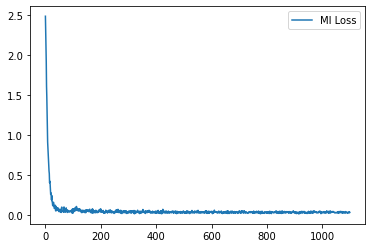

Hierarchical Node Embedding with Supervised Learning
Modularity :  tensor([0.9572], device='cuda:0', grad_fn=<AddBackward0>)
# Communities :  167
MI_MAT shape: (#nodes, #nodes)  torch.Size([230, 230])
 ------- During training: train, valid, test  0.5563380281690141 0.5681818181818182 0.5454545454545454
Step [1/1], Loss: 1.1195, Dealed Nodes [0/142] 
Epoch_[0]-----Results: Train F1 0 Validation F1 0 Test F1 0
Modularity :  tensor([0.9572], device='cuda:0', grad_fn=<AddBackward0>)
# Communities :  167
MI_MAT shape: (#nodes, #nodes)  torch.Size([230, 230])
 ------- During training: train, valid, test  0.6056338028169014 0.6590909090909091 0.6136363636363636
Step [1/1], Loss: 1.0066, Dealed Nodes [0/142] 
Modularity :  tensor([0.9572], device='cuda:0')
# Communities :  167
MI_MAT shape: (#nodes, #nodes)  torch.Size([230, 230])
Epoch_[1]-----Results: Train F1 0.6549295774647887 Validation F1 0.7045454545454546 Test F1 0.7045454545454546
Modularity :  tensor([0.9572], device='cuda:0', grad_f

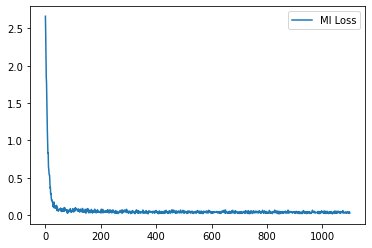

Hierarchical Node Embedding with Supervised Learning
Modularity :  tensor([0.9494], device='cuda:0', grad_fn=<AddBackward0>)
# Communities :  163
MI_MAT shape: (#nodes, #nodes)  torch.Size([230, 230])
 ------- During training: train, valid, test  0.06338028169014084 0.09090909090909091 0.045454545454545456
Step [1/1], Loss: 4.6033, Dealed Nodes [0/142] 
Epoch_[0]-----Results: Train F1 0 Validation F1 0 Test F1 0
Modularity :  tensor([0.9494], device='cuda:0', grad_fn=<AddBackward0>)
# Communities :  163
MI_MAT shape: (#nodes, #nodes)  torch.Size([230, 230])
 ------- During training: train, valid, test  0.06338028169014084 0.09090909090909091 0.045454545454545456
Step [1/1], Loss: 4.0621, Dealed Nodes [0/142] 
Modularity :  tensor([0.9494], device='cuda:0')
# Communities :  163
MI_MAT shape: (#nodes, #nodes)  torch.Size([230, 230])
Epoch_[1]-----Results: Train F1 0.06338028169014084 Validation F1 0.09090909090909091 Test F1 0.09090909090909091
Modularity :  tensor([0.9494], device='cuda

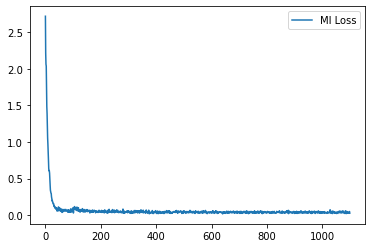

Hierarchical Node Embedding with Supervised Learning
Modularity :  tensor([0.9560], device='cuda:0', grad_fn=<AddBackward0>)
# Communities :  165
MI_MAT shape: (#nodes, #nodes)  torch.Size([230, 230])
 ------- During training: train, valid, test  0.823943661971831 0.7045454545454546 0.75
Step [1/1], Loss: 0.6584, Dealed Nodes [0/142] 
Epoch_[0]-----Results: Train F1 0 Validation F1 0 Test F1 0
Modularity :  tensor([0.9560], device='cuda:0', grad_fn=<AddBackward0>)
# Communities :  165
MI_MAT shape: (#nodes, #nodes)  torch.Size([230, 230])
 ------- During training: train, valid, test  0.8380281690140845 0.6818181818181818 0.75
Step [1/1], Loss: 0.6181, Dealed Nodes [0/142] 
Modularity :  tensor([0.9560], device='cuda:0')
# Communities :  165
MI_MAT shape: (#nodes, #nodes)  torch.Size([230, 230])
Epoch_[1]-----Results: Train F1 0.8450704225352113 Validation F1 0.7272727272727273 Test F1 0.75
Modularity :  tensor([0.9560], device='cuda:0', grad_fn=<AddBackward0>)
# Communities :  165
MI_M

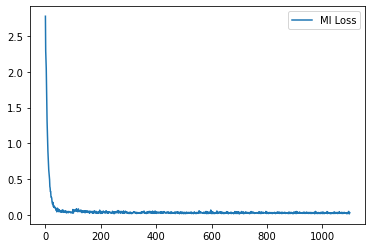

Hierarchical Node Embedding with Supervised Learning
Modularity :  tensor([0.9537], device='cuda:0', grad_fn=<AddBackward0>)
# Communities :  167
MI_MAT shape: (#nodes, #nodes)  torch.Size([230, 230])
 ------- During training: train, valid, test  0.3380281690140845 0.36363636363636365 0.36363636363636365
Step [1/1], Loss: 1.5765, Dealed Nodes [0/142] 
Epoch_[0]-----Results: Train F1 0 Validation F1 0 Test F1 0
Modularity :  tensor([0.9537], device='cuda:0', grad_fn=<AddBackward0>)
# Communities :  167
MI_MAT shape: (#nodes, #nodes)  torch.Size([230, 230])
 ------- During training: train, valid, test  0.37323943661971837 0.38636363636363635 0.38636363636363635
Step [1/1], Loss: 1.3406, Dealed Nodes [0/142] 
Modularity :  tensor([0.9537], device='cuda:0')
# Communities :  167
MI_MAT shape: (#nodes, #nodes)  torch.Size([230, 230])
Epoch_[1]-----Results: Train F1 0.45774647887323944 Validation F1 0.45454545454545453 Test F1 0.45454545454545453
Modularity :  tensor([0.9537], device='cuda:0'

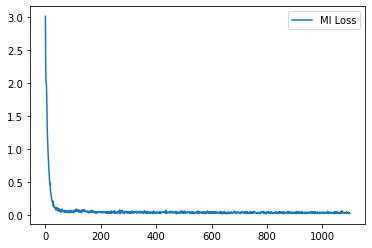

Hierarchical Node Embedding with Supervised Learning
Modularity :  tensor([0.9547], device='cuda:0', grad_fn=<AddBackward0>)
# Communities :  168
MI_MAT shape: (#nodes, #nodes)  torch.Size([230, 230])
 ------- During training: train, valid, test  0.3591549295774648 0.3181818181818182 0.3409090909090909
Step [1/1], Loss: 1.4195, Dealed Nodes [0/142] 
Epoch_[0]-----Results: Train F1 0 Validation F1 0 Test F1 0
Modularity :  tensor([0.9547], device='cuda:0', grad_fn=<AddBackward0>)
# Communities :  168
MI_MAT shape: (#nodes, #nodes)  torch.Size([230, 230])
 ------- During training: train, valid, test  0.44366197183098594 0.38636363636363635 0.4318181818181818
Step [1/1], Loss: 1.2429, Dealed Nodes [0/142] 
Modularity :  tensor([0.9547], device='cuda:0')
# Communities :  168
MI_MAT shape: (#nodes, #nodes)  torch.Size([230, 230])
Epoch_[1]-----Results: Train F1 0.5492957746478874 Validation F1 0.4772727272727273 Test F1 0.5909090909090909
Modularity :  tensor([0.9547], device='cuda:0', grad

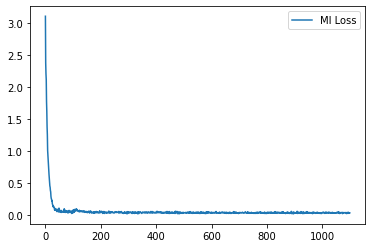

Hierarchical Node Embedding with Supervised Learning
Modularity :  tensor([0.9525], device='cuda:0', grad_fn=<AddBackward0>)
# Communities :  167
MI_MAT shape: (#nodes, #nodes)  torch.Size([230, 230])
 ------- During training: train, valid, test  0.19014084507042256 0.22727272727272727 0.20454545454545456
Step [1/1], Loss: 1.5629, Dealed Nodes [0/142] 
Epoch_[0]-----Results: Train F1 0 Validation F1 0 Test F1 0
Modularity :  tensor([0.9525], device='cuda:0', grad_fn=<AddBackward0>)
# Communities :  167
MI_MAT shape: (#nodes, #nodes)  torch.Size([230, 230])
 ------- During training: train, valid, test  0.352112676056338 0.3181818181818182 0.38636363636363635
Step [1/1], Loss: 1.2945, Dealed Nodes [0/142] 
Modularity :  tensor([0.9525], device='cuda:0')
# Communities :  167
MI_MAT shape: (#nodes, #nodes)  torch.Size([230, 230])
Epoch_[1]-----Results: Train F1 0.5422535211267606 Validation F1 0.45454545454545453 Test F1 0.5454545454545454
Modularity :  tensor([0.9525], device='cuda:0', gr

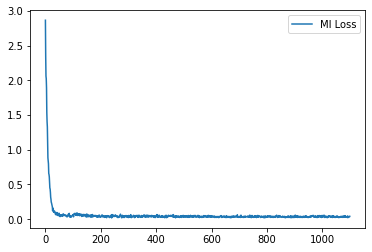

Hierarchical Node Embedding with Supervised Learning
Modularity :  tensor([0.9574], device='cuda:0', grad_fn=<AddBackward0>)
# Communities :  166
MI_MAT shape: (#nodes, #nodes)  torch.Size([230, 230])
 ------- During training: train, valid, test  0.19718309859154928 0.25 0.25
Step [1/1], Loss: 2.2936, Dealed Nodes [0/142] 
Epoch_[0]-----Results: Train F1 0 Validation F1 0 Test F1 0
Modularity :  tensor([0.9574], device='cuda:0', grad_fn=<AddBackward0>)
# Communities :  166
MI_MAT shape: (#nodes, #nodes)  torch.Size([230, 230])
 ------- During training: train, valid, test  0.24647887323943662 0.29545454545454547 0.3181818181818182
Step [1/1], Loss: 2.0322, Dealed Nodes [0/142] 
Modularity :  tensor([0.9574], device='cuda:0')
# Communities :  166
MI_MAT shape: (#nodes, #nodes)  torch.Size([230, 230])
Epoch_[1]-----Results: Train F1 0.2887323943661972 Validation F1 0.2727272727272727 Test F1 0.3409090909090909
Modularity :  tensor([0.9574], device='cuda:0', grad_fn=<AddBackward0>)
# Commu

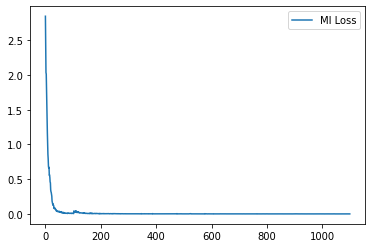

Hierarchical Node Embedding with Supervised Learning
Modularity :  tensor([0.9506], device='cuda:0', grad_fn=<AddBackward0>)
# Communities :  163
MI_MAT shape: (#nodes, #nodes)  torch.Size([230, 230])
 ------- During training: train, valid, test  0.28169014084507044 0.29545454545454547 0.29545454545454547
Step [1/1], Loss: 2.4982, Dealed Nodes [0/142] 
Epoch_[0]-----Results: Train F1 0 Validation F1 0 Test F1 0
Modularity :  tensor([0.9506], device='cuda:0', grad_fn=<AddBackward0>)
# Communities :  163
MI_MAT shape: (#nodes, #nodes)  torch.Size([230, 230])
 ------- During training: train, valid, test  0.2887323943661972 0.29545454545454547 0.29545454545454547
Step [1/1], Loss: 2.1799, Dealed Nodes [0/142] 
Modularity :  tensor([0.9506], device='cuda:0')
# Communities :  163
MI_MAT shape: (#nodes, #nodes)  torch.Size([230, 230])
Epoch_[1]-----Results: Train F1 0.29577464788732394 Validation F1 0.3181818181818182 Test F1 0.3181818181818182
Modularity :  tensor([0.9506], device='cuda:0', 

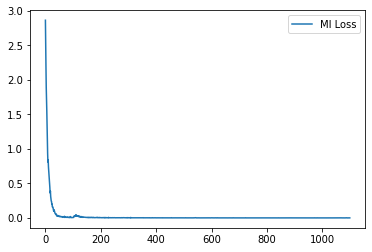

Hierarchical Node Embedding with Supervised Learning
Modularity :  tensor([0.9539], device='cuda:0', grad_fn=<AddBackward0>)
# Communities :  172
MI_MAT shape: (#nodes, #nodes)  torch.Size([230, 230])
 ------- During training: train, valid, test  0.14084507042253522 0.09090909090909091 0.09090909090909091
Step [1/1], Loss: 2.3265, Dealed Nodes [0/142] 
Epoch_[0]-----Results: Train F1 0 Validation F1 0 Test F1 0
Modularity :  tensor([0.9539], device='cuda:0', grad_fn=<AddBackward0>)
# Communities :  172
MI_MAT shape: (#nodes, #nodes)  torch.Size([230, 230])
 ------- During training: train, valid, test  0.19718309859154928 0.13636363636363635 0.11363636363636363
Step [1/1], Loss: 1.9489, Dealed Nodes [0/142] 
Modularity :  tensor([0.9539], device='cuda:0')
# Communities :  172
MI_MAT shape: (#nodes, #nodes)  torch.Size([230, 230])
Epoch_[1]-----Results: Train F1 0.3028169014084507 Validation F1 0.25 Test F1 0.25
Modularity :  tensor([0.9539], device='cuda:0', grad_fn=<AddBackward0>)
# Co

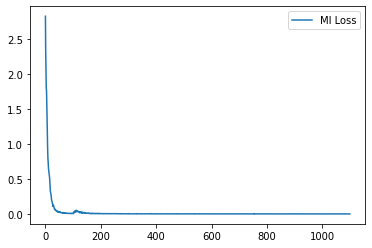

Hierarchical Node Embedding with Supervised Learning
Modularity :  tensor([0.9482], device='cuda:0', grad_fn=<AddBackward0>)
# Communities :  161
MI_MAT shape: (#nodes, #nodes)  torch.Size([230, 230])
 ------- During training: train, valid, test  0.7183098591549296 0.6363636363636364 0.6590909090909091
Step [1/1], Loss: 1.0109, Dealed Nodes [0/142] 
Epoch_[0]-----Results: Train F1 0 Validation F1 0 Test F1 0
Modularity :  tensor([0.9482], device='cuda:0', grad_fn=<AddBackward0>)
# Communities :  161
MI_MAT shape: (#nodes, #nodes)  torch.Size([230, 230])
 ------- During training: train, valid, test  0.73943661971831 0.6818181818181818 0.7045454545454546
Step [1/1], Loss: 0.9258, Dealed Nodes [0/142] 
Modularity :  tensor([0.9482], device='cuda:0')
# Communities :  161
MI_MAT shape: (#nodes, #nodes)  torch.Size([230, 230])
Epoch_[1]-----Results: Train F1 0.7464788732394367 Validation F1 0.6818181818181818 Test F1 0.75
Modularity :  tensor([0.9482], device='cuda:0', grad_fn=<AddBackward0>

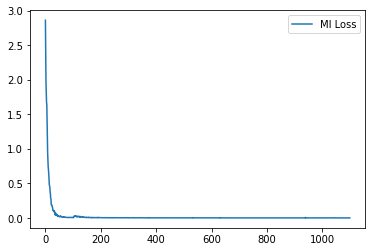

Hierarchical Node Embedding with Supervised Learning
Modularity :  tensor([0.9489], device='cuda:0', grad_fn=<AddBackward0>)
# Communities :  162
MI_MAT shape: (#nodes, #nodes)  torch.Size([230, 230])
 ------- During training: train, valid, test  0.3591549295774648 0.25 0.2727272727272727
Step [1/1], Loss: 1.8154, Dealed Nodes [0/142] 
Epoch_[0]-----Results: Train F1 0 Validation F1 0 Test F1 0
Modularity :  tensor([0.9489], device='cuda:0', grad_fn=<AddBackward0>)
# Communities :  162
MI_MAT shape: (#nodes, #nodes)  torch.Size([230, 230])
 ------- During training: train, valid, test  0.4647887323943662 0.29545454545454547 0.3409090909090909
Step [1/1], Loss: 1.5354, Dealed Nodes [0/142] 
Modularity :  tensor([0.9489], device='cuda:0')
# Communities :  162
MI_MAT shape: (#nodes, #nodes)  torch.Size([230, 230])
Epoch_[1]-----Results: Train F1 0.5774647887323944 Validation F1 0.4090909090909091 Test F1 0.4090909090909091
Modularity :  tensor([0.9489], device='cuda:0', grad_fn=<AddBackwar

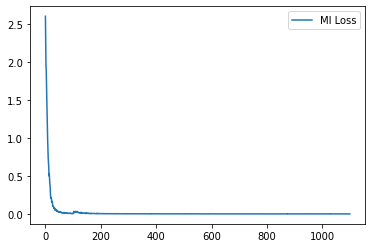

Hierarchical Node Embedding with Supervised Learning
Modularity :  tensor([0.9489], device='cuda:0', grad_fn=<AddBackward0>)
# Communities :  167
MI_MAT shape: (#nodes, #nodes)  torch.Size([230, 230])
 ------- During training: train, valid, test  0.028169014084507043 0.022727272727272728 0.045454545454545456
Step [1/1], Loss: 3.2390, Dealed Nodes [0/142] 
Epoch_[0]-----Results: Train F1 0 Validation F1 0 Test F1 0
Modularity :  tensor([0.9489], device='cuda:0', grad_fn=<AddBackward0>)
# Communities :  167
MI_MAT shape: (#nodes, #nodes)  torch.Size([230, 230])
 ------- During training: train, valid, test  0.028169014084507043 0.022727272727272728 0.06818181818181818
Step [1/1], Loss: 2.7085, Dealed Nodes [0/142] 
Modularity :  tensor([0.9489], device='cuda:0')
# Communities :  167
MI_MAT shape: (#nodes, #nodes)  torch.Size([230, 230])
Epoch_[1]-----Results: Train F1 0.04225352112676056 Validation F1 0.045454545454545456 Test F1 0.09090909090909091
Modularity :  tensor([0.9489], device='

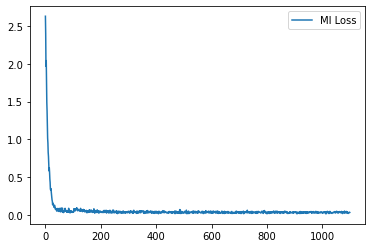

Hierarchical Node Embedding with Supervised Learning
Modularity :  tensor([0.9576], device='cuda:0', grad_fn=<AddBackward0>)
# Communities :  171
MI_MAT shape: (#nodes, #nodes)  torch.Size([230, 230])
 ------- During training: train, valid, test  0.04929577464788732 0.09090909090909091 0.045454545454545456
Step [1/1], Loss: 4.1110, Dealed Nodes [0/142] 
Epoch_[0]-----Results: Train F1 0 Validation F1 0 Test F1 0
Modularity :  tensor([0.9576], device='cuda:0', grad_fn=<AddBackward0>)
# Communities :  171
MI_MAT shape: (#nodes, #nodes)  torch.Size([230, 230])
 ------- During training: train, valid, test  0.056338028169014086 0.11363636363636363 0.045454545454545456
Step [1/1], Loss: 3.7278, Dealed Nodes [0/142] 
Modularity :  tensor([0.9576], device='cuda:0')
# Communities :  171
MI_MAT shape: (#nodes, #nodes)  torch.Size([230, 230])
Epoch_[1]-----Results: Train F1 0.056338028169014086 Validation F1 0.13636363636363635 Test F1 0.13636363636363635
Modularity :  tensor([0.9576], device='cu

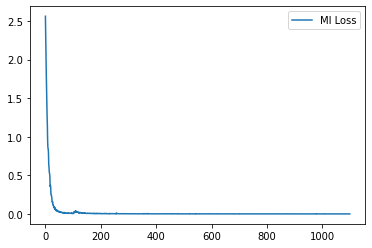

Hierarchical Node Embedding with Supervised Learning
Modularity :  tensor([0.9471], device='cuda:0', grad_fn=<AddBackward0>)
# Communities :  161
MI_MAT shape: (#nodes, #nodes)  torch.Size([230, 230])
 ------- During training: train, valid, test  0.2535211267605634 0.29545454545454547 0.3409090909090909
Step [1/1], Loss: 2.5482, Dealed Nodes [0/142] 
Epoch_[0]-----Results: Train F1 0 Validation F1 0 Test F1 0
Modularity :  tensor([0.9471], device='cuda:0', grad_fn=<AddBackward0>)
# Communities :  161
MI_MAT shape: (#nodes, #nodes)  torch.Size([230, 230])
 ------- During training: train, valid, test  0.2746478873239437 0.3181818181818182 0.3409090909090909
Step [1/1], Loss: 2.1042, Dealed Nodes [0/142] 
Modularity :  tensor([0.9471], device='cuda:0')
# Communities :  161
MI_MAT shape: (#nodes, #nodes)  torch.Size([230, 230])
Epoch_[1]-----Results: Train F1 0.2887323943661972 Validation F1 0.3409090909090909 Test F1 0.3409090909090909
Modularity :  tensor([0.9471], device='cuda:0', grad_

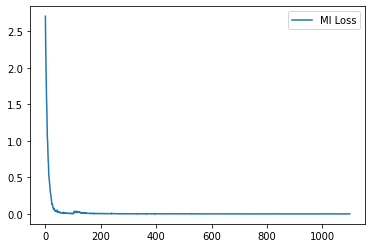

Hierarchical Node Embedding with Supervised Learning
Modularity :  tensor([0.9522], device='cuda:0', grad_fn=<AddBackward0>)
# Communities :  172
MI_MAT shape: (#nodes, #nodes)  torch.Size([230, 230])
 ------- During training: train, valid, test  0.20422535211267606 0.29545454545454547 0.1590909090909091
Step [1/1], Loss: 1.8461, Dealed Nodes [0/142] 
Epoch_[0]-----Results: Train F1 0 Validation F1 0 Test F1 0
Modularity :  tensor([0.9522], device='cuda:0', grad_fn=<AddBackward0>)
# Communities :  172
MI_MAT shape: (#nodes, #nodes)  torch.Size([230, 230])
 ------- During training: train, valid, test  0.33098591549295775 0.38636363636363635 0.29545454545454547
Step [1/1], Loss: 1.6036, Dealed Nodes [0/142] 
Modularity :  tensor([0.9522], device='cuda:0')
# Communities :  172
MI_MAT shape: (#nodes, #nodes)  torch.Size([230, 230])
Epoch_[1]-----Results: Train F1 0.4507042253521127 Validation F1 0.5 Test F1 0.5
Modularity :  tensor([0.9522], device='cuda:0', grad_fn=<AddBackward0>)
# Commu

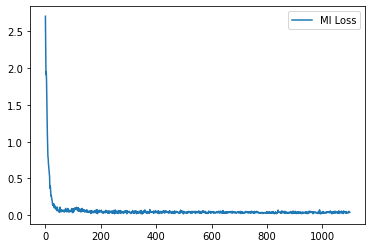

Hierarchical Node Embedding with Supervised Learning
Modularity :  tensor([0.9622], device='cuda:0', grad_fn=<AddBackward0>)
# Communities :  171
MI_MAT shape: (#nodes, #nodes)  torch.Size([230, 230])
 ------- During training: train, valid, test  0.28169014084507044 0.2727272727272727 0.29545454545454547
Step [1/1], Loss: 2.0524, Dealed Nodes [0/142] 
Epoch_[0]-----Results: Train F1 0 Validation F1 0 Test F1 0
Modularity :  tensor([0.9622], device='cuda:0', grad_fn=<AddBackward0>)
# Communities :  171
MI_MAT shape: (#nodes, #nodes)  torch.Size([230, 230])
 ------- During training: train, valid, test  0.34507042253521125 0.3409090909090909 0.36363636363636365
Step [1/1], Loss: 1.7760, Dealed Nodes [0/142] 
Modularity :  tensor([0.9622], device='cuda:0')
# Communities :  171
MI_MAT shape: (#nodes, #nodes)  torch.Size([230, 230])
Epoch_[1]-----Results: Train F1 0.3802816901408451 Validation F1 0.3409090909090909 Test F1 0.4090909090909091
Modularity :  tensor([0.9622], device='cuda:0', gr

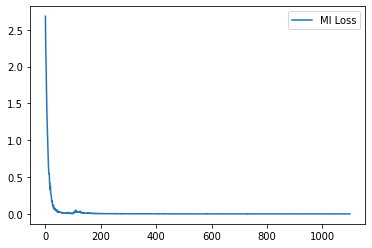

Hierarchical Node Embedding with Supervised Learning
Modularity :  tensor([0.9541], device='cuda:0', grad_fn=<AddBackward0>)
# Communities :  167
MI_MAT shape: (#nodes, #nodes)  torch.Size([230, 230])
 ------- During training: train, valid, test  0.056338028169014086 0.11363636363636363 0.11363636363636363
Step [1/1], Loss: 3.3565, Dealed Nodes [0/142] 
Epoch_[0]-----Results: Train F1 0 Validation F1 0 Test F1 0
Modularity :  tensor([0.9541], device='cuda:0', grad_fn=<AddBackward0>)
# Communities :  167
MI_MAT shape: (#nodes, #nodes)  torch.Size([230, 230])
 ------- During training: train, valid, test  0.07746478873239436 0.13636363636363635 0.18181818181818182
Step [1/1], Loss: 2.7913, Dealed Nodes [0/142] 
Modularity :  tensor([0.9541], device='cuda:0')
# Communities :  167
MI_MAT shape: (#nodes, #nodes)  torch.Size([230, 230])
Epoch_[1]-----Results: Train F1 0.16901408450704225 Validation F1 0.1590909090909091 Test F1 0.18181818181818182
Modularity :  tensor([0.9541], device='cuda:0

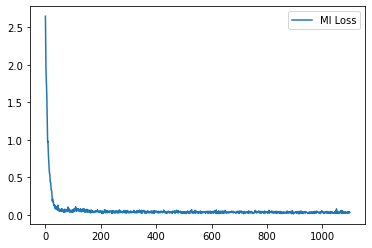

Hierarchical Node Embedding with Supervised Learning
Modularity :  tensor([0.9393], device='cuda:0', grad_fn=<AddBackward0>)
# Communities :  166
MI_MAT shape: (#nodes, #nodes)  torch.Size([230, 230])
 ------- During training: train, valid, test  0.07746478873239436 0.13636363636363635 0.09090909090909091
Step [1/1], Loss: 2.0322, Dealed Nodes [0/142] 
Epoch_[0]-----Results: Train F1 0 Validation F1 0 Test F1 0
Modularity :  tensor([0.9393], device='cuda:0', grad_fn=<AddBackward0>)
# Communities :  166
MI_MAT shape: (#nodes, #nodes)  torch.Size([230, 230])
 ------- During training: train, valid, test  0.14084507042253522 0.22727272727272727 0.1590909090909091
Step [1/1], Loss: 1.7114, Dealed Nodes [0/142] 
Modularity :  tensor([0.9393], device='cuda:0')
# Communities :  166
MI_MAT shape: (#nodes, #nodes)  torch.Size([230, 230])
Epoch_[1]-----Results: Train F1 0.2676056338028169 Validation F1 0.3181818181818182 Test F1 0.36363636363636365
Modularity :  tensor([0.9393], device='cuda:0', 

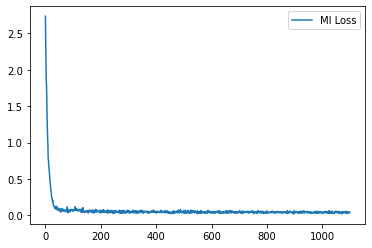

Hierarchical Node Embedding with Supervised Learning
Modularity :  tensor([0.9420], device='cuda:0', grad_fn=<AddBackward0>)
# Communities :  162
MI_MAT shape: (#nodes, #nodes)  torch.Size([230, 230])
 ------- During training: train, valid, test  0.056338028169014086 0.06818181818181818 0.045454545454545456
Step [1/1], Loss: 2.5555, Dealed Nodes [0/142] 
Epoch_[0]-----Results: Train F1 0 Validation F1 0 Test F1 0
Modularity :  tensor([0.9420], device='cuda:0', grad_fn=<AddBackward0>)
# Communities :  162
MI_MAT shape: (#nodes, #nodes)  torch.Size([230, 230])
 ------- During training: train, valid, test  0.07042253521126761 0.09090909090909091 0.09090909090909091
Step [1/1], Loss: 2.1240, Dealed Nodes [0/142] 
Modularity :  tensor([0.9420], device='cuda:0')
# Communities :  162
MI_MAT shape: (#nodes, #nodes)  torch.Size([230, 230])
Epoch_[1]-----Results: Train F1 0.14084507042253522 Validation F1 0.20454545454545456 Test F1 0.20454545454545456
Modularity :  tensor([0.9420], device='cuda

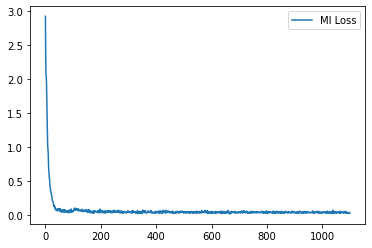

Hierarchical Node Embedding with Supervised Learning
Modularity :  tensor([0.9503], device='cuda:0', grad_fn=<AddBackward0>)
# Communities :  162
MI_MAT shape: (#nodes, #nodes)  torch.Size([230, 230])
 ------- During training: train, valid, test  0.14084507042253522 0.13636363636363635 0.22727272727272727
Step [1/1], Loss: 2.5627, Dealed Nodes [0/142] 
Epoch_[0]-----Results: Train F1 0 Validation F1 0 Test F1 0
Modularity :  tensor([0.9503], device='cuda:0', grad_fn=<AddBackward0>)
# Communities :  162
MI_MAT shape: (#nodes, #nodes)  torch.Size([230, 230])
 ------- During training: train, valid, test  0.19014084507042256 0.25 0.25
Step [1/1], Loss: 2.2470, Dealed Nodes [0/142] 
Modularity :  tensor([0.9503], device='cuda:0')
# Communities :  162
MI_MAT shape: (#nodes, #nodes)  torch.Size([230, 230])
Epoch_[1]-----Results: Train F1 0.28169014084507044 Validation F1 0.29545454545454547 Test F1 0.29545454545454547
Modularity :  tensor([0.9503], device='cuda:0', grad_fn=<AddBackward0>)
# C

In [ ]:


parser = argparse.ArgumentParser(description='pytorch version of LnL-GNN Model')
parser.add_argument('-f')
parser.add_argument('--dataSet', type=str, default='washington')
parser.add_argument('--agg_func', type=str, default='MEAN')
parser.add_argument('--epochs', type=int, default=201)
parser.add_argument('--b_sz', type=int, default=300)
parser.add_argument('--seed', type=int, default=42)
parser.add_argument('--mi_epochs', type=int, default=1100)
parser.add_argument('--mi_b_sz', type=int, default=300)
parser.add_argument('--version', type=int, default=13)
parser.add_argument('--cuda', type=bool, default=True)
parser.add_argument('--load_run', type=bool, default=False)
parser.add_argument('--save_model', type=bool, default=False)
parser.add_argument('--gcn', action='store_true')
parser.add_argument('--learn_method', type=str, default='sup')
parser.add_argument('--unsup_loss', type=str, default='normal')
parser.add_argument('--max_vali_f1', type=float, default=0)
parser.add_argument('--name', type=str, default='debug')

parser.add_argument('--config', type=str, default='/content/drive/My Drive/RAShip_Implementation/experiments.conf')
parser.add_argument('--result', type=str, default='/content/drive/My Drive/RAShip_Implementation/H-MINE (aaai)/Results')
args = parser.parse_args()
PATH = '/content/drive/My Drive/RAShip_Implementation'


if torch.cuda.is_available():
	if not args.cuda:
		print(args.cuda)
		print("WARNING: You have a CUDA device, so you should probably run with --cuda")
	else:
		device_id = torch.cuda.current_device()
	print('using device', device_id, torch.cuda.get_device_name(device_id))
  
device = torch.device("cuda" if args.cuda else "cpu")
print('DEVICE:', device)


if __name__ == '__main__':
	# random.seed(args.seed)
	# np.random.seed(args.seed)
	# torch.manual_seed(args.seed)
	# torch.cuda.manual_seed_all(args.seed)
 
  # load config file
	config = pyhocon.ConfigFactory.parse_file(args.config)
	
	file_name = args.result + '/' + args.dataSet + '_model_summary' + '.csv'

	title = 'Run No, Epoch,' \
					'Max Train F1, oMax Validation F1, Max Test F1,' \
					'Train F1, Validation F1, Test F1,' \
					'Learning Rate, Hidden Size' \
					'\n'
	

	for run_no in range(20):
		args.version = run_no
		ds = args.dataSet
		dataCenter = DataCenter(config)
		dataCenter.load_dataSet(ds)
		features = torch.FloatTensor(getattr(dataCenter, ds+'_feats')).to(device)
		labels = getattr(dataCenter, ds+'_labels')
		adj_lists = getattr(dataCenter, ds+'_adj_lists')
		all_nodes = getattr(dataCenter, ds+'_all_nodes')
		train_nodes = getattr(dataCenter, ds+'_train')
		val_nodes = getattr(dataCenter, ds+'_val')
		test_nodes = getattr(dataCenter, ds+'_test')
		# Centrality(adj_lists).get_lcm()

	#  (self, feat_in_size, feat_out_size, num_cluster, num_layers, feat_mat, adj_mat, gcn, device, agg_func='mean')
		self_size=128
		
		num_class = len(set(labels))
		
		print('num_class : ', num_class)
		num_cluster=[0, 128, 128, 128]
		num_layers=1
		dropout = 0.5
		gcn= True
		agg_func=args.agg_func
		samp_prob = get_same_class_neighbor_ratio(adj_lists, labels)
		# hModel.to(device)
		
		num_labels = len(set(getattr(dataCenter, ds+'_labels')))
		# embd_size = feat_out_size
	
	# classification.to(device)

 
		dgi_disc = Discriminator(self_size)
		if args.load_run is False:
			train_buffer = [str(d) for d in train_nodes]
			val_buffer = [str(d) for d in val_nodes]
			test_buffer = [str(d) for d in test_nodes]

			train_name = PATH + '/' + args.dataSet + '/train_{}'.format(args.version) + '.txt'
			test_name = PATH + '/' + args.dataSet + '/test_{}'.format(args.version) + '.txt'
			val_name = PATH + '/' + args.dataSet + '/val_{}'.format(args.version) + '.txt'

			train_file = ffopen(train_name, 'w')
			val_file = ffopen(val_name, 'w')
			test_file = ffopen(test_name, 'w')

			train_buffer = ','.join(train_buffer) + '\n'
			train_file.write(train_buffer)
			test_buffer = ','.join(test_buffer) + '\n'
			test_file.write(test_buffer)
			val_buffer = ','.join(val_buffer) + '\n'
			val_file.write(val_buffer)
			train_file.close()
			val_file.close()
			test_file.close()


			mi_estimator =  MIEstimator(self_size)
			slayer = ESLayer(features.size(1), self_size)
			
			train_mie = TrainMIE(dataCenter)
			
			classification = Classification(self_size, num_labels)

			slayer.to(device)
			classification.to(device)
			mi_estimator.to(device)
			
			# train_mie.to(device)
			# mi_estimator.load_state_dict(torch.load(PATH + '/' + args.dataSet + "/mi_estimator_{}.torch".format(args.version), map_location=device))
			# mi_estimator.eval()
			# slayer.load_state_dict(torch.load(PATH + '/' + args.dataSet + "/slayer_{}.torch".format(args.version), map_location=device))
			# slayer.eval()
			mi_estimator, slayer, classification = train_mie.apply(mi_estimator, slayer, classification, args.mi_epochs)

			if args.save_model is True:
				torch.save(mi_estimator.state_dict(), PATH + '/' + args.dataSet + "/mi_estimator_{}.torch".format(args.version))
				torch.save(slayer.state_dict(), PATH + '/' + args.dataSet + "/slayer_{}.torch".format(args.version))
		else:
			train_name = PATH + '/' + args.dataSet + '/train_{}'.format(args.version) + '.txt'
			test_name = PATH + '/' + args.dataSet + '/test_{}'.format(args.version) + '.txt'
			val_name = PATH + '/' + args.dataSet + '/val_{}'.format(args.version) + '.txt'
			
			mi_estimator =  MIEstimator(self_size)
			slayer = ESLayer(features.size(1), self_size)
	 
			mi_estimator.load_state_dict(torch.load(PATH + '/' + args.dataSet + "/mi_estimator_{}.torch".format(args.version), map_location=device))
			mi_estimator.eval()
			slayer.load_state_dict(torch.load(PATH + '/' + args.dataSet + "/slayer_{}.torch".format(args.version), map_location=device))
			slayer.eval()
	 		
			if torch.cuda.is_available():
				mi_estimator.cuda()
				slayer.cuda()

			train_nodes = []
			with open(train_name) as fp:
				for i, line in enumerate(fp):
						info = line.strip().split(',')
						train_nodes += info


			val_nodes = []
			with open(val_name) as fp:
				for i, line in enumerate(fp):
						info = line.strip().split(',')
						val_nodes += info

			test_nodes = []
			with open(test_name) as fp:
				for i, line in enumerate(fp):
						info = line.strip().split(',')
						test_nodes += info

			train_nodes = [int(i) for i in train_nodes]
			val_nodes = [int(i) for i in val_nodes]
			test_nodes = [int(i) for i in test_nodes]

			# print('Train Nodes: ', train_nodes)
			# print('Val Nodes: ', val_nodes)
			# print('test Nodes: ', test_nodes)

			setattr(dataCenter, ds+'_train', train_nodes)
			setattr(dataCenter, ds+'_val', val_nodes)
			setattr(dataCenter, ds+'_test', test_nodes)

		feat_out_size=128
		embd_size = feat_out_size
		hModel = HierarchicalModel(features.size(1), feat_out_size, self_size, num_class, num_cluster, num_layers,dropout, samp_prob, labels,
	                           gcn, device)
		classification = Classification(embd_size, num_labels)
		if args.load_run is False:
			hModel.to(device)                           
			classification.to(device)

			if args.learn_method == 'sup':
				print('Hierarchical Node Embedding with Supervised Learning')

			ctr = 1
			max_test_f1 = 0
			max_vali_f1 = 0
			max_train_f1 = 0
			
			for epoch in range(args.epochs):

				if epoch%100 == 0:
					max_test_f1 = 0
					max_vali_f1 = 0
					max_train_f1 = 0

					if epoch != 0:
						result_file = ffopen(file_name, 'a',title)
						buffer = [str(d) for d in data]
						
						buf = ','.join(buffer) + '\n'
						result_file.write(buf)

						result_file.close()
				

				applyModel =  ApplyModel(dataCenter, hModel, classification, mi_estimator, slayer, dgi_disc)
				# applyModel.to(device)
				if epoch == 0:
					training = True
				else:
					training = False

				hModel, classification, slayer, loss, ttnf1, sl, cl = applyModel.apply_model(ds, args.b_sz, device, args.learn_method, training)
		
				# torch.save(hModel.state_dict(), PATH + '/' + args.dataSet + "/hModel_{}.torch".format(args.version))
				# torch.save(classification.state_dict(), PATH + '/' + args.dataSet + "/classification_{}.torch".format(args.version))
				
				if (epoch%1==0) and (epoch > 0):
					train_f1, val_f1, test_f1, etnl, evl, ettl = evaluate(dataCenter, ds, hModel, classification, mi_estimator, slayer, device, max_vali_f1,max_test_f1, args.name, epoch)
					
					if (val_f1 > max_vali_f1) and (args.save_model is True):
						torch.save(hModel.state_dict(), PATH + '/' + args.dataSet + "/hModel_{}.torch".format(args.version))
						torch.save(classification.state_dict(), PATH + '/' + args.dataSet + "/classification_{}.torch".format(args.version))
					max_test_f1 = max(test_f1, max_test_f1)
					max_train_f1 = max(train_f1, max_train_f1)
					max_vali_f1 = max(val_f1, max_vali_f1)
					data = [run_no+1, epoch+1,
									round(max_train_f1, 4)*100, round(max_vali_f1, 4)*100, round(max_test_f1, 4)*100,
									round(train_f1, 4)*100, round(val_f1, 4)*100, round(test_f1, 4)*100,
											0.007, 128]
				print('Epoch_[{}]-----Results: Train F1 {} Validation F1 {} Test F1 {}'.format(epoch, max_train_f1, max_vali_f1, max_test_f1) )
		else:
			
			hModel.load_state_dict(torch.load(PATH + '/' + args.dataSet + "/hModel_{}.torch".format(args.version), map_location=device))
			hModel.eval()
			classification.load_state_dict(torch.load(PATH + '/' + args.dataSet + "/classification_{}.torch".format(args.version), map_location=device))
			classification.eval()
			
			hModel.to(device)                           
			classification.to(device)
			train_f1, val_f1, test_f1, etnl, evl, ettl = evaluate(dataCenter, ds, hModel, classification, mi_estimator, slayer, device, -1, -1, args.name, -1)
	 		
			print('Train Accuracy: {} Test Accurracy: {}'.format(train_f1, test_f1))
	 

	 		



In [ ]:
print(300%100)
# mi_estimator, slayer, classification  = train_mie.apply(mi_estimator, slayer, classification, 303)

0


In [ ]:
train_nodes = getattr(dataCenter, ds+'_train')
com_model = Louvain()
community = Community(com_model, device)
setattr(community, 'adj_dic', adj_lists)
sfeats = slayer(features)

com2node_dic, node2com_dic = community(sfeats, mi_estimator, train_nodes)
scsc, scdc, dcsc, dcdc = 0, 0, 0, 0
for u in adj_lists:
  for v in adj_lists[u]:
    if u == v:
      print(u, v)
    if node2com_dic[u] == node2com_dic[v]:
      if labels[u] == labels[v]:
        scsc += 1
        print('Same Classs & Com --- Nodes: ', u, v, labels[u], labels[v])
        weight = SoftPlus(mi_estimator(sfeats[u], sfeats[v]))
        print('Weight: ', weight)
      else:
        dcsc += 1
        # print('Diff Classs &  Same Com --- Nodes: ', u, v, labels[u], labels[v])
        # weight = SoftPlus(mi_estimator(sfeats[u], sfeats[v]))
        # print('Weight: ', weight)
    else:
      if labels[u] == labels[v]:
        scdc += 1
        print('Same Classs & Diff Com --- Nodes: ', u, v, labels[u], labels[v])
        weight = SoftPlus(mi_estimator(sfeats[u], sfeats[v]))
        print('Weight: ', weight)
      else:
        dcdc+= 1
        print('Diff Classs &  Diff Com --- Nodes: ', u, v, labels[u], labels[v])
        weight = SoftPlus(mi_estimator(sfeats[u], sfeats[v]))
        print('Weight: ', weight)
print('Same CLass & Same Com: ', scsc)
print('Diff Class & Same Com: ', dcsc)
print('Same CLass & Diff Com: ', scdc)
print('Diff Class & Diff Com: ', dcdc)

Modularity :  tensor([0.9503], device='cuda:0', grad_fn=<AddBackward0>)
# Communities :  162
0 0
Same Classs & Com --- Nodes:  0 0 0 0
Weight:  tensor([3.2370], device='cuda:0', grad_fn=<SubBackward0>)
Diff Classs &  Diff Com --- Nodes:  0 103 0 3
Weight:  tensor([-11.8086], device='cuda:0', grad_fn=<SubBackward0>)
Diff Classs &  Diff Com --- Nodes:  0 202 0 2
Weight:  tensor([-13.1948], device='cuda:0', grad_fn=<SubBackward0>)
Diff Classs &  Diff Com --- Nodes:  0 174 0 2
Weight:  tensor([-11.0764], device='cuda:0', grad_fn=<SubBackward0>)
Diff Classs &  Diff Com --- Nodes:  0 120 0 2
Weight:  tensor([-9.0667], device='cuda:0', grad_fn=<SubBackward0>)
Diff Classs &  Diff Com --- Nodes:  120 0 2 0
Weight:  tensor([-7.4344], device='cuda:0', grad_fn=<SubBackward0>)
Diff Classs &  Diff Com --- Nodes:  120 1 2 1
Weight:  tensor([-17.7431], device='cuda:0', grad_fn=<SubBackward0>)
Diff Classs &  Diff Com --- Nodes:  120 31 2 1
Weight:  tensor([-20.8359], device='cuda:0', grad_fn=<SubBackwa

In [ ]:
for u in adj_lists:
  sem = 0
  scom = 0
  for v in adj_lists[u]:
    if labels[u] == labels[v]:
      sem += 1
      if node2com_dic[u] ==  node2com_dic[v]:
        scom += 1
  print('Node: ', u ,' Stats: ', len(adj_lists[u]), sem, scom)
    

Node:  0  Stats:  5 1 1
Node:  120  Stats:  3 0 0
Node:  174  Stats:  5 1 1
Node:  202  Stats:  2 0 0
Node:  1  Stats:  122 7 7
Node:  6  Stats:  2 1 1
Node:  20  Stats:  3 2 2
Node:  25  Stats:  2 1 1
Node:  29  Stats:  2 2 2
Node:  32  Stats:  1 1 1
Node:  42  Stats:  3 2 2
Node:  46  Stats:  8 1 1
Node:  67  Stats:  1 0 0
Node:  68  Stats:  2 1 1
Node:  71  Stats:  6 0 0
Node:  72  Stats:  4 0 0
Node:  73  Stats:  2 0 0
Node:  74  Stats:  4 1 1
Node:  77  Stats:  11 0 0
Node:  78  Stats:  4 0 0
Node:  81  Stats:  2 0 0
Node:  82  Stats:  7 3 3
Node:  83  Stats:  3 1 1
Node:  84  Stats:  3 1 1
Node:  85  Stats:  2 0 0
Node:  86  Stats:  4 0 0
Node:  87  Stats:  1 0 0
Node:  88  Stats:  3 1 0
Node:  89  Stats:  4 1 1
Node:  90  Stats:  7 6 6
Node:  91  Stats:  1 0 0
Node:  92  Stats:  3 0 0
Node:  93  Stats:  2 0 0
Node:  94  Stats:  3 2 2
Node:  96  Stats:  5 2 1
Node:  97  Stats:  2 1 1
Node:  98  Stats:  4 1 1
Node:  99  Stats:  2 0 0
Node:  100  Stats:  7 0 0
Node:  101  Stats:  3

In [ ]:
all_nodes = getattr(dataCenter, ds+'_all_nodes')
labels = getattr(dataCenter, ds+'_labels')


train_nodes = getattr(dataCenter, ds+'_train')

mx_cnt = 0
s_cnt = 0

# vt_nodes = set(all_nodes) - set(train_nodes)
embds = slayer(normalize_features(features))

l2n_dic = dict()
for i in all_nodes:
  if labels[i] not in l2n_dic:
    l2n_dic[labels[i]] = []
  l2n_dic[labels[i]].append(i)


for i in all_nodes:
  mx_c = 0
  mx = -1
  fn = 0
  fp = 0
  csum = dict()
  for j in all_nodes:
    if i == j:
      continue

    val = F.relu(mi_estimator(embds[i], embds[j]))
    if labels[j] not in csum:
      csum[labels[j]] = 0
    csum[labels[j]] += val.item()
    if labels[i] == labels[j]:
      if val <= 0:
        fn += 1
        # print("Same class: ", val)
      
      if mx < val:
        val = mx
        mx_c = labels[j]
        # print('Maxed in Same class')
    else:
      if val > 0:
        fp += 1
        # print("different class: ", val)
      
      if mx < val:
        mx = val
        mx_c = labels[j]
        # print('Max in Different class')
  
  s_mx = 0
  mx_s = -1
  for j in csum:
    
    csum[j] /= len(l2n_dic[j])
    # print(csum[j], j)
    if s_mx < csum[j]:
      mx_s = j
      s_mx = csum[j]

  if labels[i] != mx_s:
    print("Classification: ", labels[i], mx_c, mx_s)
  if labels[i]!= mx_c:
    mx_cnt += 1
  if labels[i] != mx_s:
    s_cnt += 1
    
  print('Node: ', i, ' FN: ', fn, ' FP: ', fp)
print(s_cnt)
print(mx_cnt)

# LE&nLE Execution

In [ ]:
# ds = args.dataSet
# dataCenter = DataCenter(config)
# dataCenter.load_dataSet(ds)
# random.seed(args.seed)
# np.random.seed(args.seed)
# torch.manual_seed(args.seed)
# torch.cuda.manual_seed_all(args.seed)
 
hModel = HierarchicalModel(features.size(1), feat_out_size, num_class, num_cluster, num_layers,dropout, samp_prob, labels,
	                           gcn, device, agg_func)
classification = Classification(embd_size, num_labels)                           
if args.learn_method == 'sup':
  print('Hierarchical Node Embedding with Supervised Learning')
elif args.learn_method == 'plus_unsup':
  print('Hierarchical Node Embedding with Supervised Learning plus Net Unsupervised Learning')
else:
  print('Hierarchical Node Embedding with Net Unsupervised Learning')


ctr = 1
max_test_f1 = 0
args.max_vali_f1 = 0
train_f1_vt = []
ttrain_f1_vt = []
val_f1_vt = []
test_f1_vt = []
ep_vt = []
train_loss_vt = []
mi_loss_vt = []
com_loss_vt = []
sup_loss_vt = []
etn_loss_vt = []
evl_loss_vt = []
ett_loss_vt = []
train_acc_vt = []
val_acc_vt = []
test_acc_vt = []
# slayer = ESLayer(features.size(1), feat_out_size)
for epoch in range(300):
  print('----------------------EPOCH %d-----------------------' % epoch)
#   def __init__(self, data_center, hmodel, classification, upsupervised_loss, loss_func):
  applyModel =  ApplyModel(dataCenter, hModel, classification, mi_estimator, slayer, dgi_disc)
#   dataset, btch_sz, device, learn_method, optm ='SGD', lr = 0.7):
  hModel, classification, slayer, loss, ttnf1, sl, cl = applyModel.apply_model(ds, args.b_sz, device, args.learn_method)
  # , ml, cl, sl
  # mi_loss_vt.append(ml)
  com_loss_vt.append(cl)
  sup_loss_vt.append(sl)
  train_loss_vt.append(loss)
  if (epoch+1) % 2 == 0 and args.learn_method == 'unsup':
    classification, args.max_vali_f1, max_test_f1 = train_classification(dataCenter, hModel, classification, ds, device, args.max_vali_f1, max_test_f1,  args.name)
  if args.learn_method != 'unsup':
    train_f1, val_f1, test_f1, etnl, evl, ettl, train_acc, vali_acc, test_acc = evaluate(dataCenter, ds, hModel, classification, mi_estimator, slayer, device, args.max_vali_f1,max_test_f1, args.name, epoch)
    
    etn_loss_vt.append(etnl)
    evl_loss_vt.append(evl)
    ett_loss_vt.append(ettl)
    args.max_vali_f1 = max(val_f1, args.max_vali_f1)
    max_test_f1 = max(test_f1, max_test_f1)
    train_f1_vt.append(train_f1)
    val_f1_vt.append(val_f1)
    test_f1_vt.append(test_f1)		
    ttrain_f1_vt.append(ttnf1)
    # train_acc_vt.append(train_acc)
    # val_acc_vt.append(vali_acc)
    # test_acc_vt.append(test_acc)
    ep_vt.append(epoch)

  # plt.plot(ep_vt, train_loss_vt, label='Training Loss')
  plt.plot(ep_vt, train_f1_vt, label='Training F1')
  plt.plot(ep_vt, val_f1_vt, label = 'Validation F1')
  plt.plot(ep_vt, test_f1_vt, label = 'Test F1')
  plt.plot(ep_vt, ttrain_f1_vt, label='Training Train F1')
  # plt.plot(ep_vt, train_acc_vt, label='Training Acc')
  # plt.plot(ep_vt, val_acc_vt, label = 'Validation Acc')
  # plt.plot(ep_vt, test_acc_vt, label = 'Test Acc')
  plt.legend()
  plt.show() 
  print('Valid F1: ', args.max_vali_f1, ' Test F1: ', max_test_f1)
  


# Load & Run

In [ ]:
all_nodes = getattr(dataCenter, ds+'_all_nodes')
labels = getattr(dataCenter, ds+'_labels')
train_nodes = getattr(dataCenter, ds+'_train')
val_nodes = getattr(dataCenter, ds+'_val')
test_nodes = getattr(dataCenter, ds+'_test')


# print('Train Nodes: ', train_nodes)
# print('Val Nodes: ', val_nodes)
# print('test Nodes: ', test_nodes)

# train_buffer = [str(d) for d in train_nodes]
# val_buffer = [str(d) for d in val_nodes]
# test_buffer = [str(d) for d in test_nodes]

train_name = args.result + '/' + args.dataSet + '_train' + '.txt'
test_name = args.result + '/' + args.dataSet + '_test' + '.txt'
val_name = args.result + '/' + args.dataSet + '_val' + '.txt'

# train_file = ffopen(train_name, 'w')
# val_file = ffopen(val_name, 'w')
# test_file = ffopen(test_name, 'w')

# train_buffer = ','.join(train_buffer) + '\n'
# train_file.write(train_buffer)
# test_buffer = ','.join(test_buffer) + '\n'
# test_file.write(test_buffer)
# val_buffer = ','.join(val_buffer) + '\n'
# val_file.write(val_buffer)
# train_file.close()
# val_file.close()
# test_file.close()

# torch.save(mi_estimator.state_dict(), "/content/drive/My Drive/RAShip_Implementation/cora/mi_estimator.torch")
# torch.save(slayer.state_dict(), "/content/drive/My Drive/RAShip_Implementation/cora/slayer.torch")





# ds = args.dataSet
# dataCenter = DataCenter(config)
# dataCenter.load_dataSet(ds)
# random.seed(args.seed)
# np.random.seed(args.seed)
# torch.manual_seed(args.seed)
# torch.cuda.manual_seed_all(args.seed)

feat_out_size = 8
num_cluster=[0, num_class, num_class]
mi_estimator =  MIEstimator(feat_out_size)
slayer = ESLayer(features.size(1), feat_out_size)

mi_estimator.load_state_dict(torch.load('/content/drive/My Drive/RAShip_Implementation/cora/mi_estimator.torch'))
mi_estimator.eval()

slayer.load_state_dict(torch.load('/content/drive/My Drive/RAShip_Implementation/cora/slayer.torch'))
slayer.eval()

# print(mi_estimator)
# print(slayer)

# train_file = ffopen(train_name, 'r')
# val_file = ffopen(val_name, 'r')
# test_file = ffopen(test_name, 'r')

train_nodes = []
with open(train_name) as fp:
  for i, line in enumerate(fp):
      info = line.strip().split(',')
      train_nodes += info


val_nodes = []
with open(val_name) as fp:
  for i, line in enumerate(fp):
      info = line.strip().split(',')
      val_nodes += info

test_nodes = []
with open(test_name) as fp:
  for i, line in enumerate(fp):
      info = line.strip().split(',')
      test_nodes += info

train_nodes = [int(i) for i in train_nodes]
val_nodes = [int(i) for i in val_nodes]
test_nodes = [int(i) for i in test_nodes]

# print('Train Nodes: ', train_nodes)
# print('Val Nodes: ', val_nodes)
# print('test Nodes: ', test_nodes)

setattr(dataCenter, ds+'_train', train_nodes)
setattr(dataCenter, ds+'_val', val_nodes)
setattr(dataCenter, ds+'_test', test_nodes)


# for i in train_nodes:
#   if labels[i] == -1:
#     print(i)
# train_nodes = getattr(dataCenter, ds+'_train')
# val_nodes = getattr(dataCenter, ds+'_val')
# test_nodes = getattr(dataCenter, ds+'_test')


# print('Train Nodes: ', train_nodes)
# print('Val Nodes: ', val_nodes)
# print('test Nodes: ', test_nodes)

feat_out_size = 128
embd_size = 128
num_layers = 2
hModel = HierarchicalModel(features.size(1), feat_out_size, num_class, num_cluster, num_layers,dropout, samp_prob, labels,
	                           gcn, device, agg_func)
classification = Classification(embd_size, num_labels)                           
if args.learn_method == 'sup':
  print('Hierarchical Node Embedding with Supervised Learning')
elif args.learn_method == 'plus_unsup':
  print('Hierarchical Node Embedding with Supervised Learning plus Net Unsupervised Learning')
else:
  print('Hierarchical Node Embedding with Net Unsupervised Learning')


ctr = 1
max_test_f1 = 0
args.max_vali_f1 = 0
train_f1_vt = []
ttrain_f1_vt = []
val_f1_vt = []
test_f1_vt = []
ep_vt = []
train_loss_vt = []
mi_loss_vt = []
com_loss_vt = []
sup_loss_vt = []
etn_loss_vt = []
evl_loss_vt = []
ett_loss_vt = []
train_acc_vt = []
val_acc_vt = []
test_acc_vt = []
# slayer = ESLayer(features.size(1), feat_out_size)
args.b_sz = 3003
for epoch in range(2001):
  print('----------------------EPOCH %d-----------------------' % epoch)
#   def __init__(self, data_center, hmodel, classification, upsupervised_loss, loss_func):
  applyModel =  ApplyModel(dataCenter, hModel, classification, mi_estimator, slayer, dgi_disc)
#   dataset, btch_sz, device, learn_method, optm ='SGD', lr = 0.7):
  hModel, classification, slayer, loss, ttnf1 = applyModel.apply_model(ds, args.b_sz, device, args.learn_method)
  # , ml, cl, sl
  # mi_loss_vt.append(ml)
  # com_loss_vt.append(cl)
  # sup_loss_vt.append(sl)
  train_loss_vt.append(loss)
  # if (epoch+1) % 2 == 0 and args.learn_method == 'unsup':
  #   classification, args.max_vali_f1, max_test_f1 = train_classification(dataCenter, hModel, classification, ds, device, args.max_vali_f1, max_test_f1,  args.name)
  if (epoch%100 == 0) and (epoch > 0):
    val_f1, test_f1 = evaluate(dataCenter, ds, hModel, classification, mi_estimator, slayer, device, args.max_vali_f1,max_test_f1, args.name, args.b_sz)
    
    # etn_loss_vt.append(etnl)
    # evl_loss_vt.append(evl)
    # ett_loss_vt.append(ettl)
    args.max_vali_f1 = max(val_f1, args.max_vali_f1)
    max_test_f1 = max(test_f1, max_test_f1)
    # train_f1_vt.append(train_f1)
    val_f1_vt.append(val_f1)
    test_f1_vt.append(test_f1)		
    ttrain_f1_vt.append(ttnf1)
    # train_acc_vt.append(train_acc)
    # val_acc_vt.append(vali_acc)
    # test_acc_vt.append(test_acc)
    ep_vt.append(epoch)

  # plt.plot(ep_vt, train_loss_vt, label='Training Loss')
  # plt.plot(ep_vt, train_f1_vt, label='Training F1')
    plt.plot(ep_vt, val_f1_vt, label = 'Validation F1')
    plt.plot(ep_vt, test_f1_vt, label = 'Test F1')
    plt.plot(ep_vt, ttrain_f1_vt, label='Training Train F1')
    # plt.plot(ep_vt, train_acc_vt, label='Training Acc')
    # plt.plot(ep_vt, val_acc_vt, label = 'Validation Acc')
    # plt.plot(ep_vt, test_acc_vt, label = 'Test Acc')
    plt.legend()
    plt.show() 
  print('Valid F1: ', args.max_vali_f1, ' Test F1: ', max_test_f1)
  


# Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')